**Credit Scoring**

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import regex as re
from sklearn.model_selection import train_test_split, KFold
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.feature_selection import RFE

In [3]:
# !pip install ucimlrepo

<h2>Read Dataset<h2>

In [4]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
statlog_german_credit_data = fetch_ucirepo(id=144)

# data (as pandas dataframes)
X = statlog_german_credit_data.data.features
y = statlog_german_credit_data.data.targets

# metadata
print(statlog_german_credit_data.metadata)

# variable information
print(statlog_german_credit_data.variables)

{'uci_id': 144, 'name': 'Statlog (German Credit Data)', 'repository_url': 'https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data', 'data_url': 'https://archive.ics.uci.edu/static/public/144/data.csv', 'abstract': 'This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1000, 'num_features': 20, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Other', 'Marital Status', 'Age', 'Occupation'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5NC77', 'creators': ['Hans Hofmann'], 'intro_paper': None, 'additional_info': {'summary': 'Two datasets are provided.  the original dataset, in the form provided by

<h2>Rename Attributes and Fix Binary Features<h2>

In [5]:
rename_dict = {
    "Attribute1": "Checking_Account_Status",
    "Attribute2": "Loan_Duration_Months",
    "Attribute3": "Credit_History",
    "Attribute4": "Loan_Purpose",
    "Attribute5": "Credit_Amount",
    "Attribute6": "Savings_Account_Bonds",
    "Attribute7": "Employment_Duration",
    "Attribute8": "Installment_Rate_Percentage",
    "Attribute9": "Personal_Status_Sex",
    "Attribute10": "Other_Debtors_Guarantors",
    "Attribute11": "Residence_Duration",
    "Attribute12": "Owned_Property",
    "Attribute13": "Age",
    "Attribute14": "Other_Installment_Plans",
    "Attribute15": "Housing_Type",
    "Attribute16": "Existing_Credits",
    "Attribute17": "Job_Type",
    "Attribute18": "Dependents",
    "Attribute19": "Has_Telephone",
    "Attribute20": "Foreign_Worker"
}

X.rename(columns=rename_dict, inplace=True)
X['Has_Telephone'].replace({'A191': 0, 'A192': 1}, inplace=True)
X['Foreign_Worker'].replace({'A201': 1, 'A202': 0}, inplace=True)

num_columns = ["Loan_Duration_Months", "Credit_Amount", "Installment_Rate_Percentage",
               "Residence_Duration", "Age", "Existing_Credits", "Dependents"]
cat_columns = [c for c in X.columns if c not in num_columns and c != "Has_Telephone" and c != "Foreign_Worker"]
print(cat_columns)

['Checking_Account_Status', 'Credit_History', 'Loan_Purpose', 'Savings_Account_Bonds', 'Employment_Duration', 'Personal_Status_Sex', 'Other_Debtors_Guarantors', 'Owned_Property', 'Other_Installment_Plans', 'Housing_Type', 'Job_Type']


**Split Data for Preprocessing and Feature Engineering**

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
train_df = pd.concat([X_train, y_train], axis=1)
train_df.head()

(800, 20) (800, 1) (200, 20) (200, 1)


,Checking_Account_Status,Loan_Duration_Months,Credit_History,Loan_Purpose,Credit_Amount,Savings_Account_Bonds,Employment_Duration,Installment_Rate_Percentage,Personal_Status_Sex,Other_Debtors_Guarantors,...,Owned_Property,Age,Other_Installment_Plans,Housing_Type,Existing_Credits,Job_Type,Dependents,Has_Telephone,Foreign_Worker,class
675,A14,30,A34,A43,4530,A61,A74,4,A92,A101,...,A123,26,A143,A151,1,A174,1,1,1,1
358,A14,12,A32,A43,776,A61,A73,4,A94,A101,...,A121,28,A143,A152,1,A173,1,0,1,1
159,A14,6,A34,A43,1898,A65,A73,1,A93,A101,...,A121,34,A143,A152,2,A172,2,0,1,1
533,A14,24,A32,A43,1311,A62,A74,4,A94,A101,...,A122,26,A143,A152,1,A173,1,1,1,1
678,A11,24,A32,A43,2384,A61,A75,4,A93,A101,...,A121,64,A141,A151,1,A172,1,0,1,1


In [7]:
train_df.isna().any()

Checking_Account_Status        False
Loan_Duration_Months           False
Credit_History                 False
Loan_Purpose                   False
Credit_Amount                  False
Savings_Account_Bonds          False
Employment_Duration            False
Installment_Rate_Percentage    False
Personal_Status_Sex            False
Other_Debtors_Guarantors       False
Residence_Duration             False
Owned_Property                 False
Age                            False
Other_Installment_Plans        False
Housing_Type                   False
Existing_Credits               False
Job_Type                       False
Dependents                     False
Has_Telephone                  False
Foreign_Worker                 False
class                          False
dtype: bool

In [8]:
train_df.describe()

,Loan_Duration_Months,Credit_Amount,Installment_Rate_Percentage,Residence_Duration,Age,Existing_Credits,Dependents,Has_Telephone,Foreign_Worker,class
count,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,20.91500,3243.477500,2.957500,2.857500,35.615000,1.402500,1.150000,0.411250,0.970000,1.305000
std,12.26482,2819.853229,1.124622,1.090266,11.368744,0.581736,0.357295,0.492368,0.170694,0.460695
min,4.00000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,0.000000,0.000000,1.000000
25%,12.00000,1354.250000,2.000000,2.000000,27.000000,1.000000,1.000000,0.000000,1.000000,1.000000
50%,18.00000,2308.500000,3.000000,3.000000,33.000000,1.000000,1.000000,0.000000,1.000000,1.000000
75%,24.00000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,1.000000,1.000000,2.000000
max,72.00000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,1.000000,1.000000,2.000000


In [9]:
default_df = train_df[train_df['class'] == 2]
non_default_df = train_df[train_df['class'] == 1]
print(default_df.count().iloc[0], non_default_df.count().iloc[1], default_df.count().iloc[0] / (non_default_df.count().iloc[0] + default_df.count().iloc[0]))

244 556 0.305


**Useful Plots for Numerical Features**

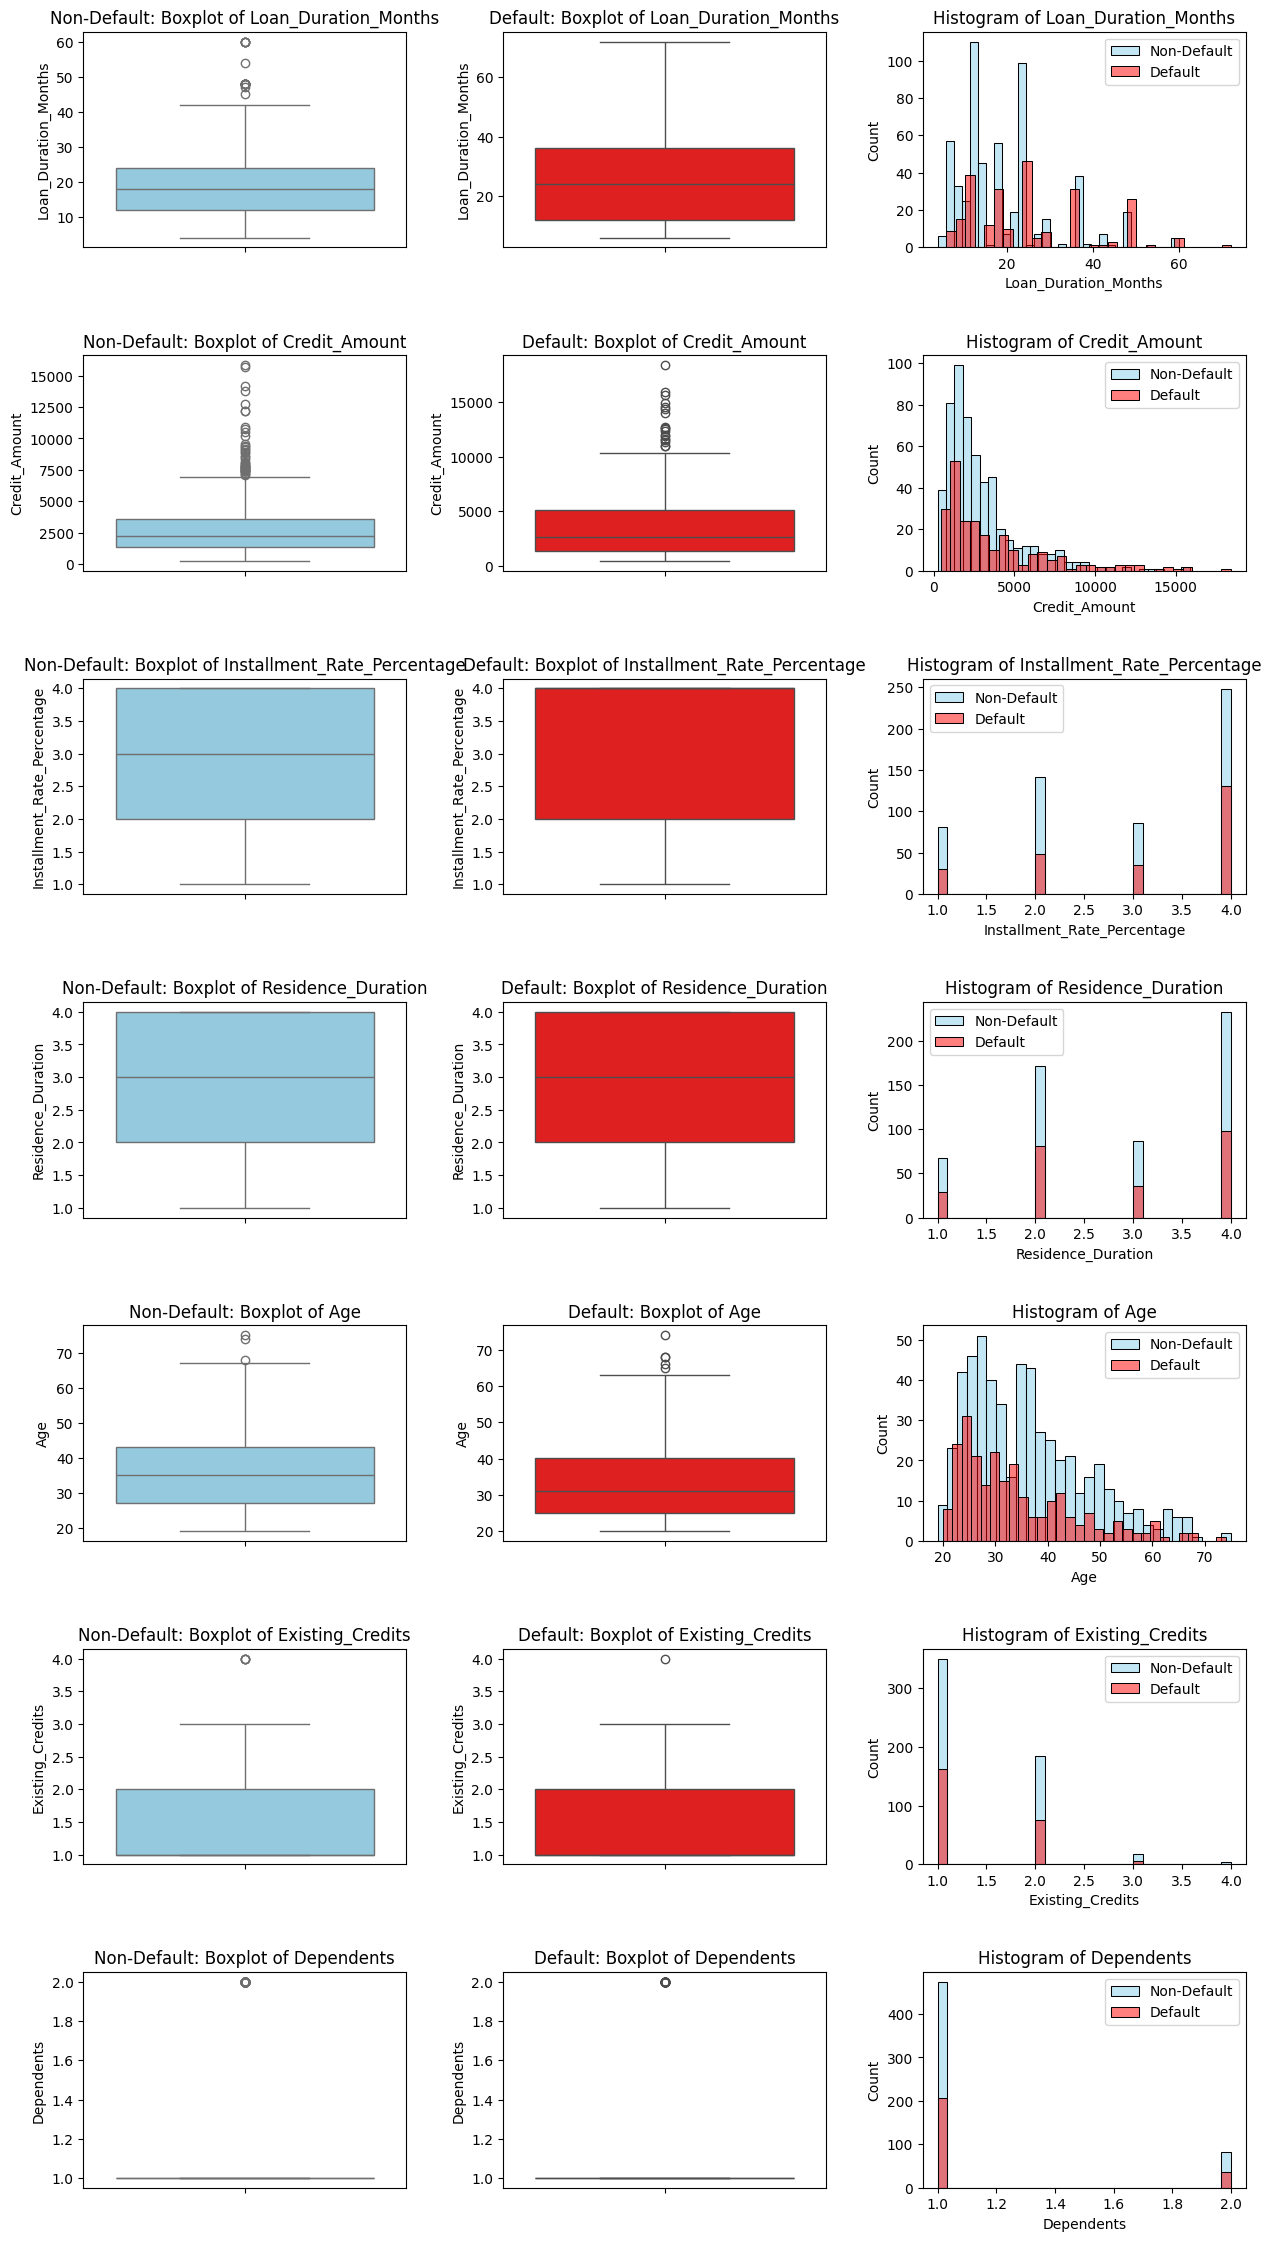

In [10]:
def plot_numerical_features(default_df, non_default_df, num_columns):
  fig, axs = plt.subplots(len(num_columns), 3, figsize=(15, 4 * len(num_columns)))

  # If there's only one numerical feature, ensure axs is treated as a 2D array
  if len(num_columns) == 1:
      axs = [axs]

  for i, feature in enumerate(num_columns):
      # Boxplot for df1
      sns.boxplot(y=non_default_df[feature], ax=axs[i][0], color='skyblue')
      axs[i][0].set_title(f'Non-Default: Boxplot of {feature}')

      # Boxplot for df2
      sns.boxplot(y=default_df[feature], ax=axs[i][1], color='red')
      axs[i][1].set_title(f'Default: Boxplot of {feature}')

      # Histogram for both datasets
      sns.histplot(non_default_df[feature], kde=False, ax=axs[i][2], color='skyblue', alpha=0.5, label='Non-Default', bins=30)
      sns.histplot(default_df[feature], kde=False, ax=axs[i][2], color='red', alpha=0.5, label='Default', bins=30)
      axs[i][2].set_title(f'Histogram of {feature}')
      axs[i][2].legend()

  plt.subplots_adjust(hspace=0.5, wspace=0.3)

  plt.show()

plot_numerical_features(default_df=default_df, non_default_df=non_default_df, num_columns=num_columns)

**Boxplot for Binary Features vs. Class and vice versa**

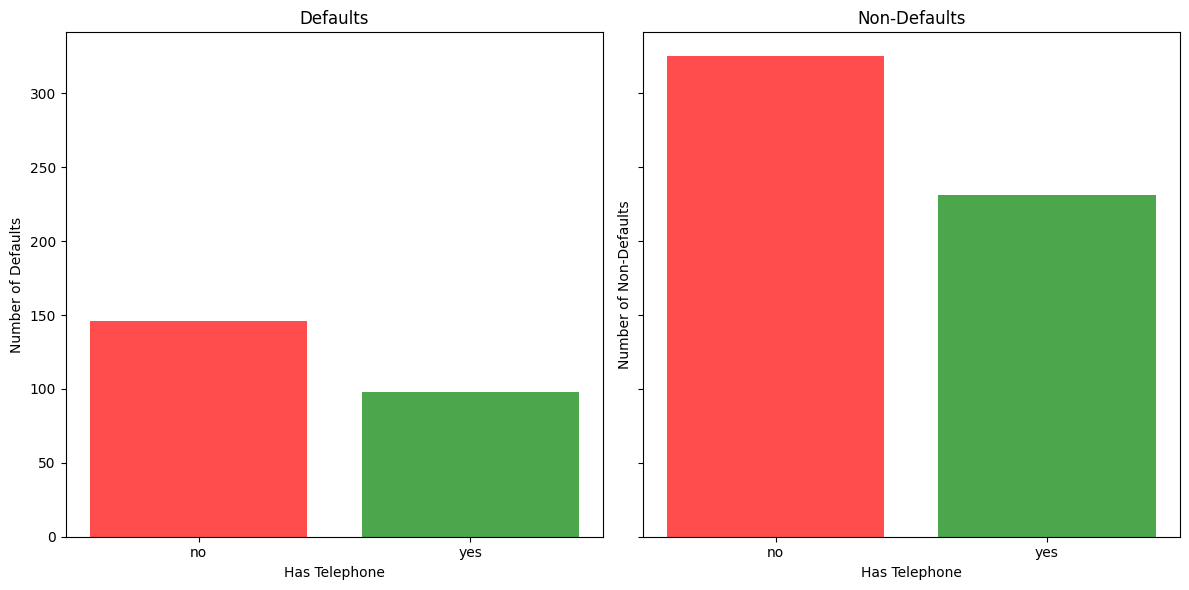

P(default|Has_Telephone) = 0.29787
P(non-default|Has_Telephone) = 0.70213


In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

counts_default = default_df['Has_Telephone'].value_counts()
axs[0].bar(counts_default.index, counts_default.values, color=['red', 'green'], alpha=0.7)
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['no', 'yes'])
axs[0].set_ylabel('Number of Defaults')
axs[0].set_xlabel('Has Telephone')
axs[0].set_title('Defaults')

counts_non_default = non_default_df['Has_Telephone'].value_counts()
axs[1].bar(counts_non_default.index, counts_non_default.values, color=['red', 'green'], alpha=0.7)
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['no', 'yes'])
axs[1].set_ylabel('Number of Non-Defaults')
axs[1].set_xlabel('Has Telephone')
axs[1].set_title('Non-Defaults')

plt.tight_layout()
plt.show()

counts_default = dict(counts_default)
counts_non_default = dict(counts_non_default)
print(f'P(default|Has_Telephone) = {counts_default[1] / (counts_default[1] + counts_non_default[1]):.5f}')
print(f'P(non-default|Has_Telephone) = {counts_non_default[1] / (counts_default[1] + counts_non_default[1]):.5f}')

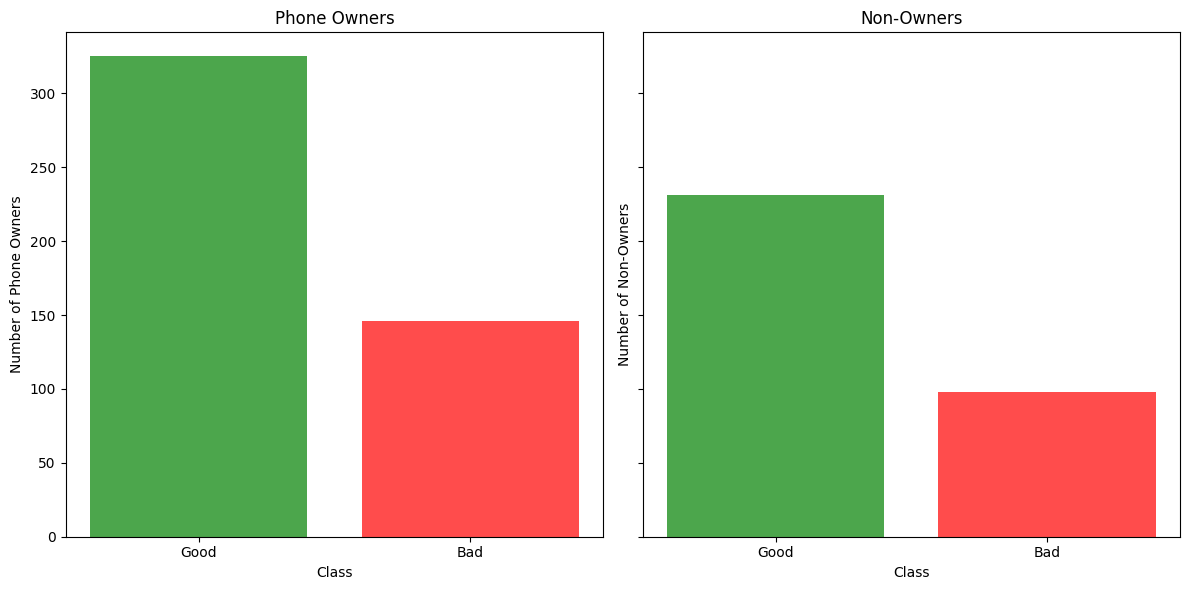

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

counts = train_df[train_df['Has_Telephone'] == 0]['class'].value_counts()
axs[0].bar(counts.index, counts.values, color=['green', 'red'], alpha=0.7)
axs[0].set_xticks([1, 2])
axs[0].set_xticklabels(['Good', 'Bad'])
axs[0].set_ylabel('Number of Phone Owners')
axs[0].set_xlabel('Class')
axs[0].set_title('Phone Owners')



counts = train_df[train_df['Has_Telephone'] == 1]['class'].value_counts()
axs[1].bar(counts.index, counts.values, color=['green', 'red'], alpha=0.7)
axs[1].set_xticks([1, 2])
axs[1].set_xticklabels(['Good', 'Bad'])
axs[1].set_ylabel('Number of Non-Owners')
axs[1].set_xlabel('Class')
axs[1].set_title('Non-Owners')

plt.tight_layout()
plt.show()

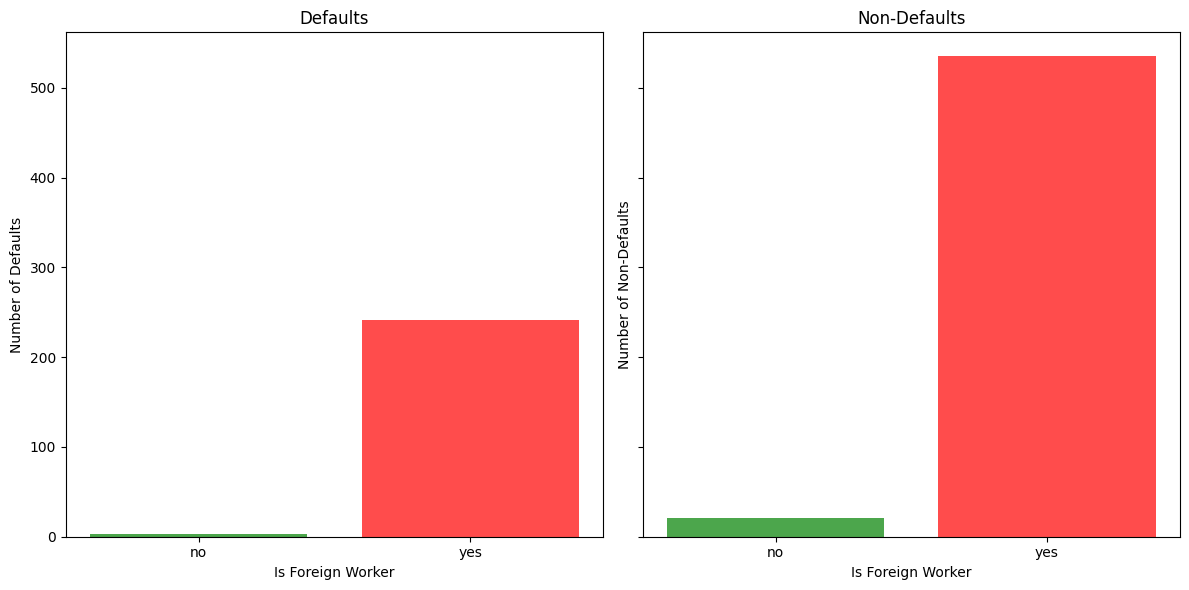

P(default|foreign_worker) = 0.12500
P(non-default|foreign_worker) = 0.87500


In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

counts_default = default_df['Foreign_Worker'].value_counts()
axs[0].bar(counts_default.index, counts_default.values, color=['red', 'green'], alpha=0.7)
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['no', 'yes'])
axs[0].set_ylabel('Number of Defaults')
axs[0].set_xlabel('Is Foreign Worker')
axs[0].set_title('Defaults')

counts_non_default = non_default_df['Foreign_Worker'].value_counts()
axs[1].bar(counts_non_default.index, counts_non_default.values, color=['red', 'green'], alpha=0.7)
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['no', 'yes'])
axs[1].set_ylabel('Number of Non-Defaults')
axs[1].set_xlabel('Is Foreign Worker')
axs[1].set_title('Non-Defaults')

plt.tight_layout()
plt.show()

counts_default = dict(counts_default)
counts_non_default = dict(counts_non_default)
print(f'P(default|foreign_worker) = {counts_default[0] / (counts_default[0] + counts_non_default[0]):.5f}')
print(f'P(non-default|foreign_worker) = {counts_non_default[0] / (counts_default[0] + counts_non_default[0]):.5f}')

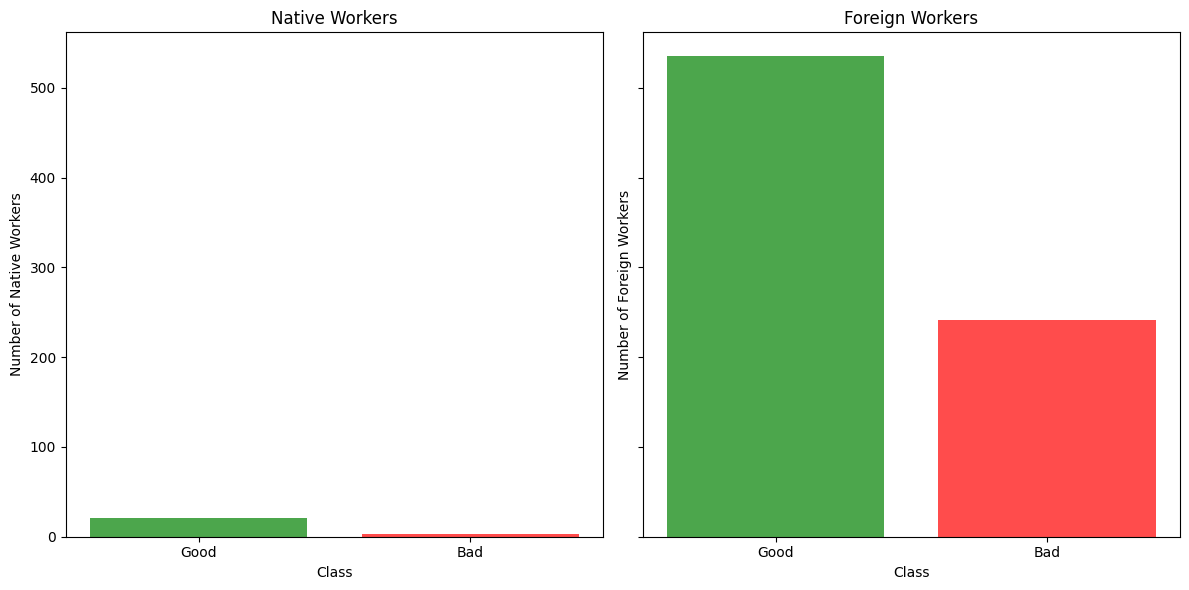

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

counts = train_df[train_df['Foreign_Worker'] == 0]['class'].value_counts()
axs[0].bar(counts.index, counts.values, color=['green', 'red'], alpha=0.7)
axs[0].set_xticks([1, 2])
axs[0].set_xticklabels(['Good', 'Bad'])
axs[0].set_ylabel('Number of Native Workers')
axs[0].set_xlabel('Class')
axs[0].set_title('Native Workers')

counts = train_df[train_df['Foreign_Worker'] == 1]['class'].value_counts()
axs[1].bar(counts.index, counts.values, color=['green', 'red'], alpha=0.7)
axs[1].set_xticks([1, 2])
axs[1].set_xticklabels(['Good', 'Bad'])
axs[1].set_ylabel('Number of Foreign Workers')
axs[1].set_xlabel('Class')
axs[1].set_title('Foreign Workers')

plt.tight_layout()
plt.show()

**Barplot for Categorical Features and Conditional Probability of Each Possible Value**

In [15]:
def plot_categorical_bar(default_df, non_default_df, feature, xticks,
                         xticklabels, label, colors, rotation=45):
  default_counts = default_df[feature].value_counts()
  default_counts = default_counts.reindex(sorted(default_counts.index), axis=0)



  fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

  axs[0].bar(default_counts.index, default_counts.values, color=colors, alpha=0.7)
  axs[0].set_xticks(xticks)
  axs[0].set_xticklabels(xticklabels, rotation=rotation)

  axs[0].set_xlabel(label)
  axs[0].set_ylabel('Default Counts')
  axs[0].set_title('Defaults')

  non_default_counts = non_default_df[feature].value_counts()
  non_default_counts = non_default_counts.reindex(sorted(non_default_counts.index), axis=0)

  axs[1].bar(non_default_counts.index, non_default_counts.values, color=colors, alpha=0.7)
  axs[1].set_xticks(xticks)
  axs[1].set_xticklabels(xticklabels, rotation=rotation)

  axs[1].set_xlabel(label)
  axs[1].set_ylabel('Non-Default Counts')
  axs[1].set_title('Non-Defaults')

  plt.show()

  default_counts = dict(default_counts.items())
  non_default_counts = dict(non_default_counts.items())

  for feature in default_counts:
    print(f'P(default|{feature}): {default_counts[feature] / (default_counts[feature] + non_default_counts[feature]):.5f}') # P(deafult|feature)
    print(f'P(non-default|{feature}): {non_default_counts[feature] / (non_default_counts[feature] + default_counts[feature]):.5f}') # P(non-default|feature)

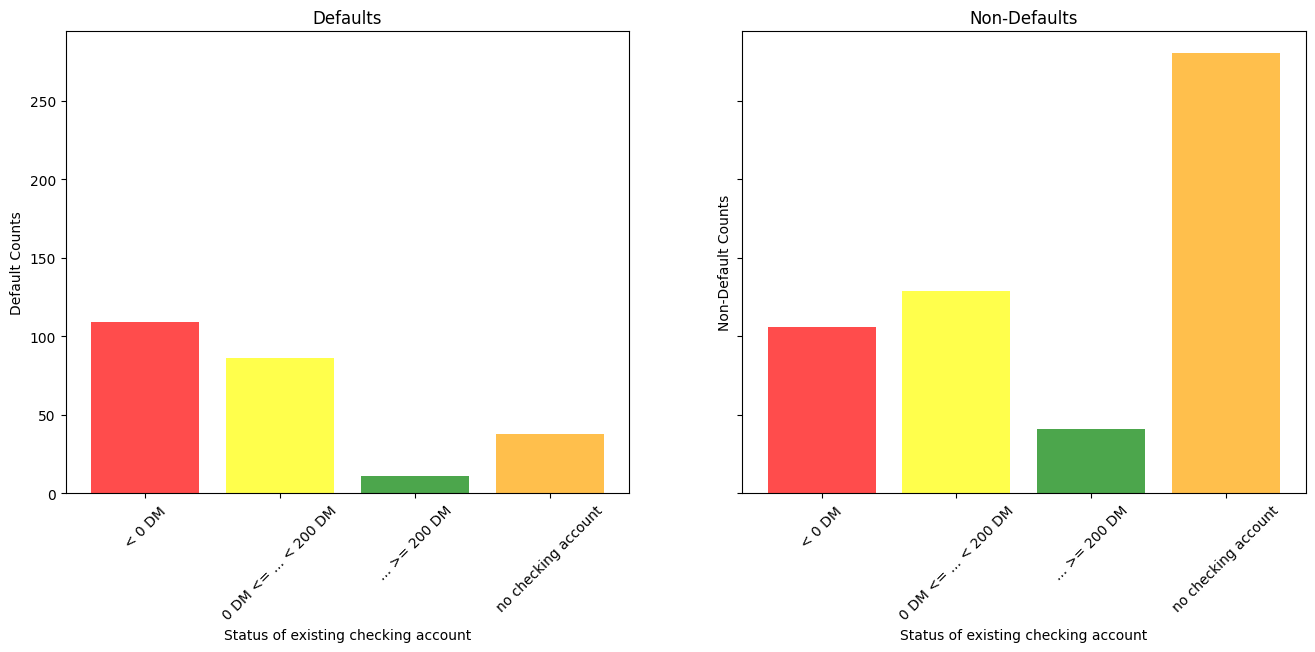

P(default|A11): 0.50698
P(non-default|A11): 0.49302
P(default|A12): 0.40000
P(non-default|A12): 0.60000
P(default|A13): 0.21154
P(non-default|A13): 0.78846
P(default|A14): 0.11950
P(non-default|A14): 0.88050


In [16]:
plot_categorical_bar(default_df, non_default_df, 'Checking_Account_Status',
                     ['A11', 'A12', 'A13', 'A14'],
                     ['< 0 DM', '0 DM <= ... < 200 DM', '... >= 200 DM',
                      'no checking account'], 'Status of existing checking account',
                     ['red', 'yellow', 'green', 'orange'])

Useful Values of *Checking_Account_Status* for 1-hot Coding: **A14, A13**

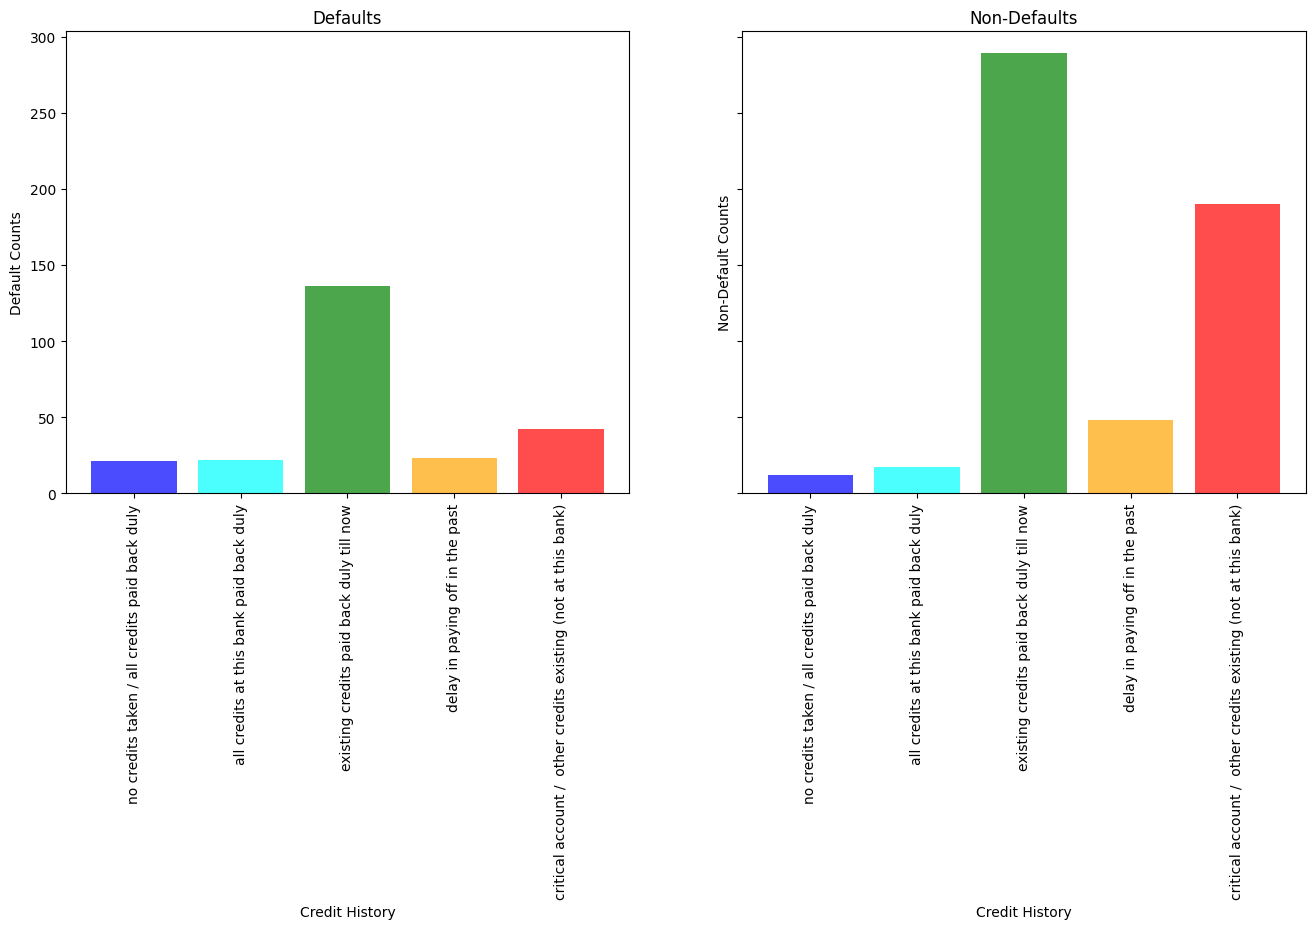

P(default|A30): 0.63636
P(non-default|A30): 0.36364
P(default|A31): 0.56410
P(non-default|A31): 0.43590
P(default|A32): 0.32000
P(non-default|A32): 0.68000
P(default|A33): 0.32394
P(non-default|A33): 0.67606
P(default|A34): 0.18103
P(non-default|A34): 0.81897


In [17]:
plot_categorical_bar(default_df, non_default_df, 'Credit_History',
                    ['A30', 'A31', 'A32', 'A33', 'A34'],
                     ['no credits taken / all credits paid back duly',
                      'all credits at this bank paid back duly',
                      'existing credits paid back duly till now',
                      'delay in paying off in the past',
                      'critical account /  other credits existing (not at this bank)'],
                     'Credit History', ['blue', 'cyan', 'green', 'orange', 'red'],
                     rotation=90)

Useful Values of *Credit_Status* for 1-hot Coding: **A34, A33, A32**

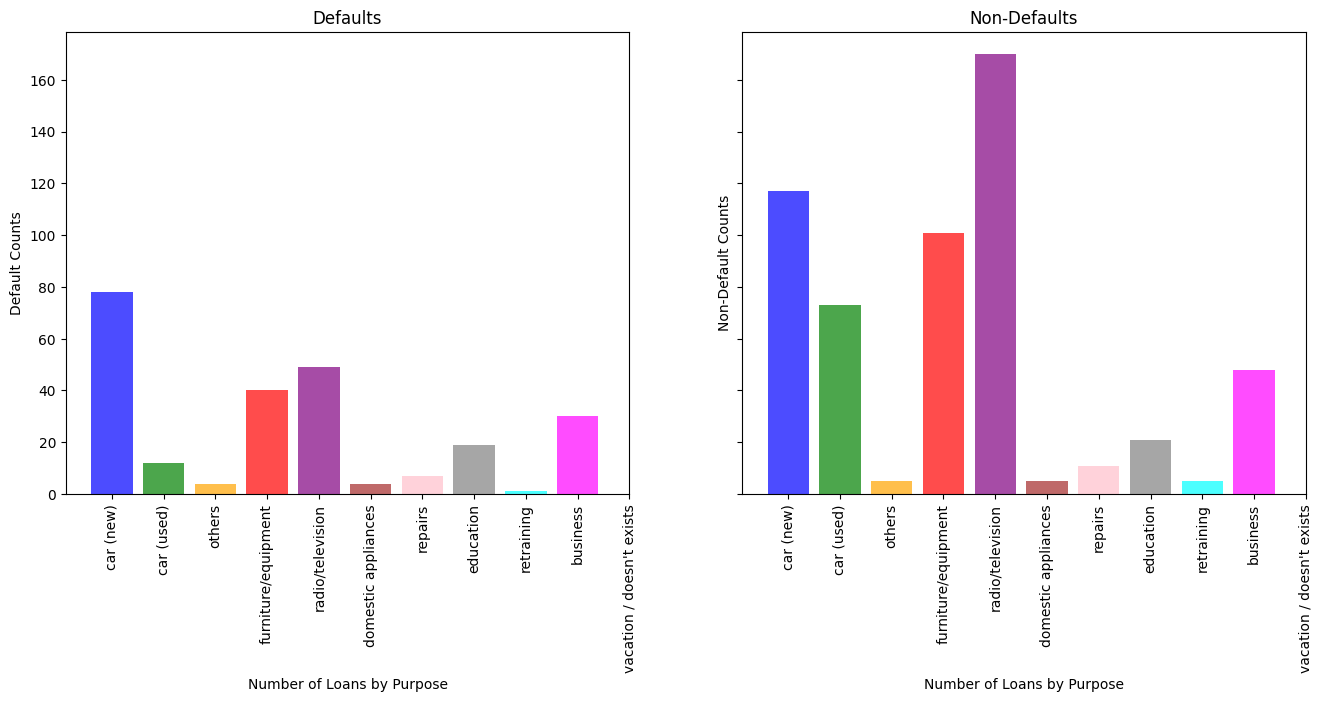

P(default|A40): 0.40000
P(non-default|A40): 0.60000
P(default|A41): 0.14118
P(non-default|A41): 0.85882
P(default|A410): 0.44444
P(non-default|A410): 0.55556
P(default|A42): 0.28369
P(non-default|A42): 0.71631
P(default|A43): 0.22374
P(non-default|A43): 0.77626
P(default|A44): 0.44444
P(non-default|A44): 0.55556
P(default|A45): 0.38889
P(non-default|A45): 0.61111
P(default|A46): 0.47500
P(non-default|A46): 0.52500
P(default|A48): 0.16667
P(non-default|A48): 0.83333
P(default|A49): 0.38462
P(non-default|A49): 0.61538


In [18]:
plot_categorical_bar(
    default_df=default_df,
    non_default_df=non_default_df,
    feature='Loan_Purpose',
    xticks=['A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A410'],
    xticklabels=[
        'car (new)', 'car (used)', 'furniture/equipment', 'radio/television',
        'domestic appliances', 'repairs', 'education', 'vacation / doesn\'t exists',
        'retraining', 'business', 'others'
    ],
    label='Number of Loans by Purpose',
    colors=['blue', 'green', 'orange', 'red', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'yellow'],
    rotation=90
)

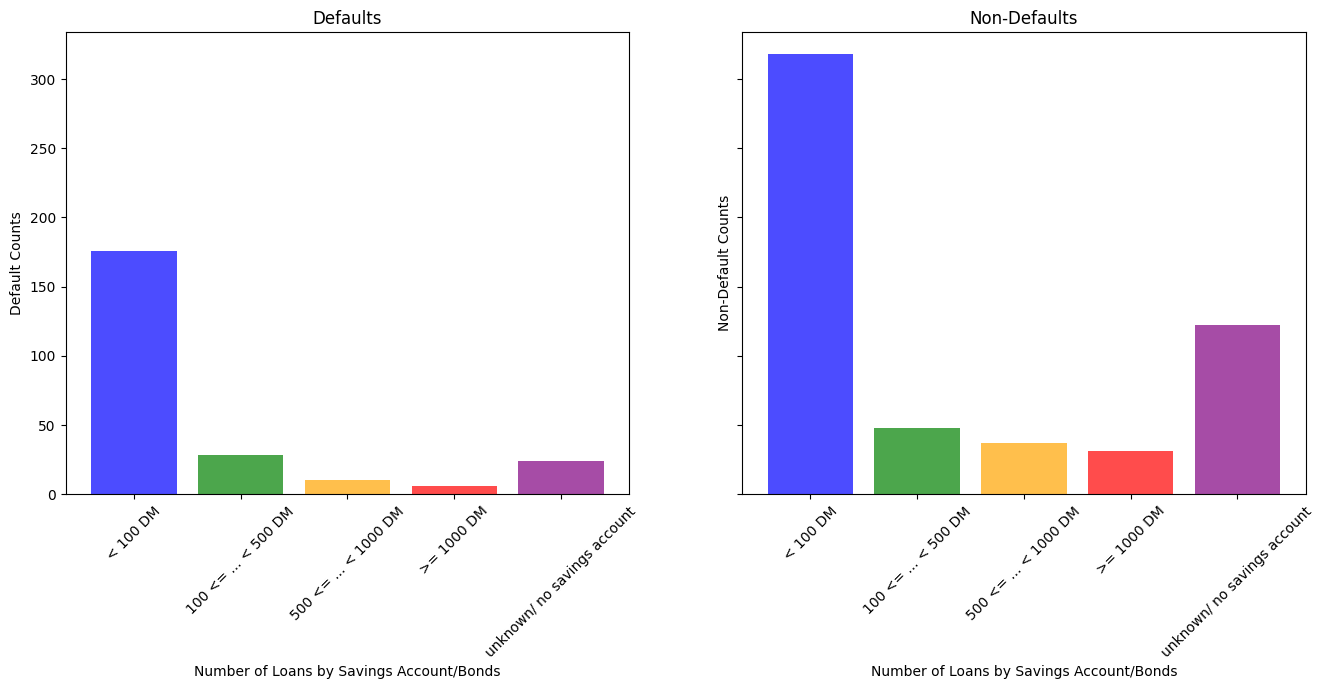

P(default|A61): 0.35628
P(non-default|A61): 0.64372
P(default|A62): 0.36842
P(non-default|A62): 0.63158
P(default|A63): 0.21277
P(non-default|A63): 0.78723
P(default|A64): 0.16216
P(non-default|A64): 0.83784
P(default|A65): 0.16438
P(non-default|A65): 0.83562


In [19]:
plot_categorical_bar(
    default_df=default_df,
    non_default_df=non_default_df,
    feature='Savings_Account_Bonds',
    xticks=['A61', 'A62', 'A63', 'A64', 'A65'],
    xticklabels=[
        '< 100 DM', '100 <= ... < 500 DM', '500 <= ... < 1000 DM', '>= 1000 DM',
        'unknown/ no savings account'
    ],
    label='Number of Loans by Savings Account/Bonds',
    colors=['blue', 'green', 'orange', 'red', 'purple']
)

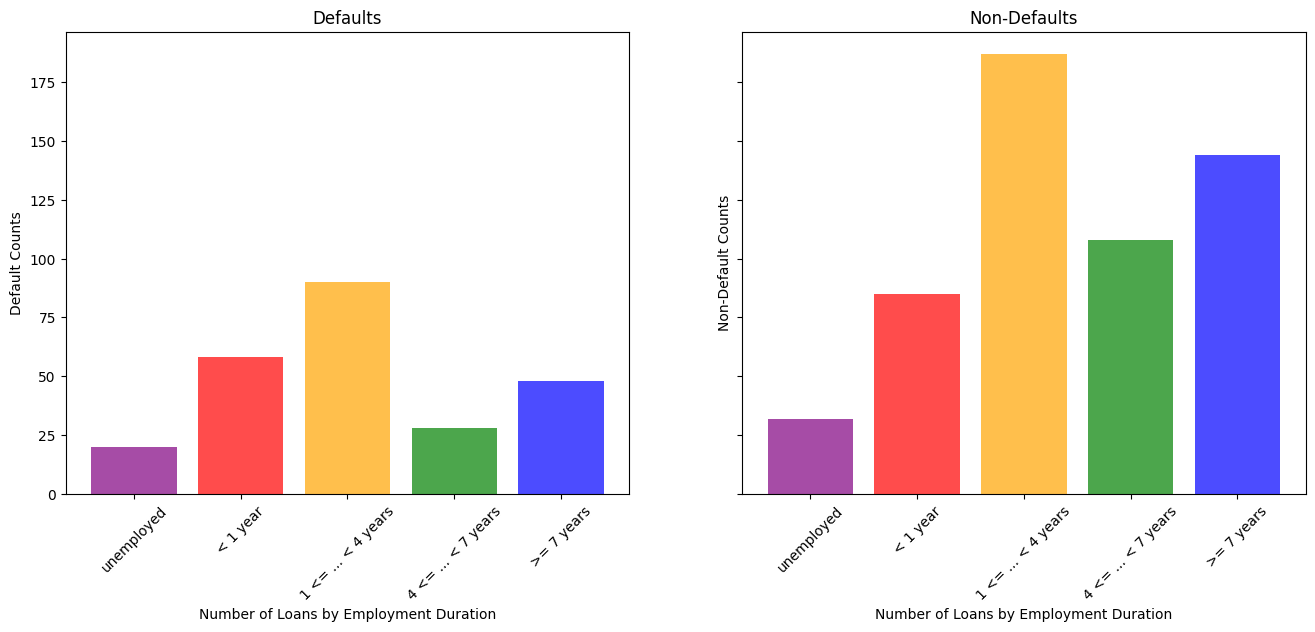

P(default|A71): 0.38462
P(non-default|A71): 0.61538
P(default|A72): 0.40559
P(non-default|A72): 0.59441
P(default|A73): 0.32491
P(non-default|A73): 0.67509
P(default|A74): 0.20588
P(non-default|A74): 0.79412
P(default|A75): 0.25000
P(non-default|A75): 0.75000


In [20]:
plot_categorical_bar(
    default_df=default_df,
    non_default_df=non_default_df,
    feature='Employment_Duration',
    xticks=['A71', 'A72', 'A73', 'A74', 'A75'],
    xticklabels=[
        'unemployed', '< 1 year', '1 <= ... < 4 years', '4 <= ... < 7 years', '>= 7 years'
    ],
    label='Number of Loans by Employment Duration',
    colors=['purple', 'red', 'orange', 'green', 'blue']
)

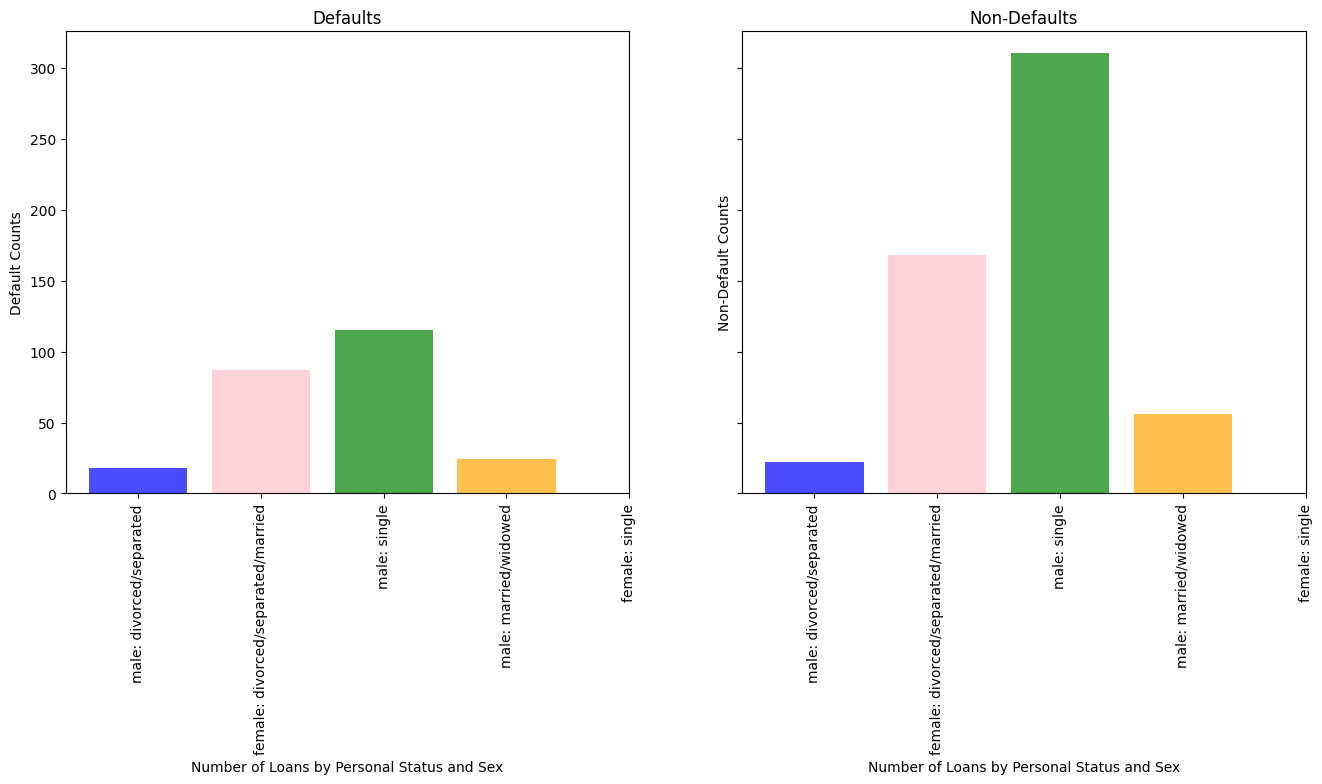

P(default|A91): 0.45000
P(non-default|A91): 0.55000
P(default|A92): 0.34118
P(non-default|A92): 0.65882
P(default|A93): 0.27059
P(non-default|A93): 0.72941
P(default|A94): 0.30000
P(non-default|A94): 0.70000


In [21]:
plot_categorical_bar(
    default_df=default_df,
    non_default_df=non_default_df,
    feature='Personal_Status_Sex',
    xticks=['A91', 'A92', 'A93', 'A94', 'A95'],
    xticklabels=[
        'male: divorced/separated', 'female: divorced/separated/married',
        'male: single', 'male: married/widowed', 'female: single'
    ],
    label='Number of Loans by Personal Status and Sex',
    colors=['blue', 'pink', 'green', 'orange', 'purple'],
    rotation=90
)

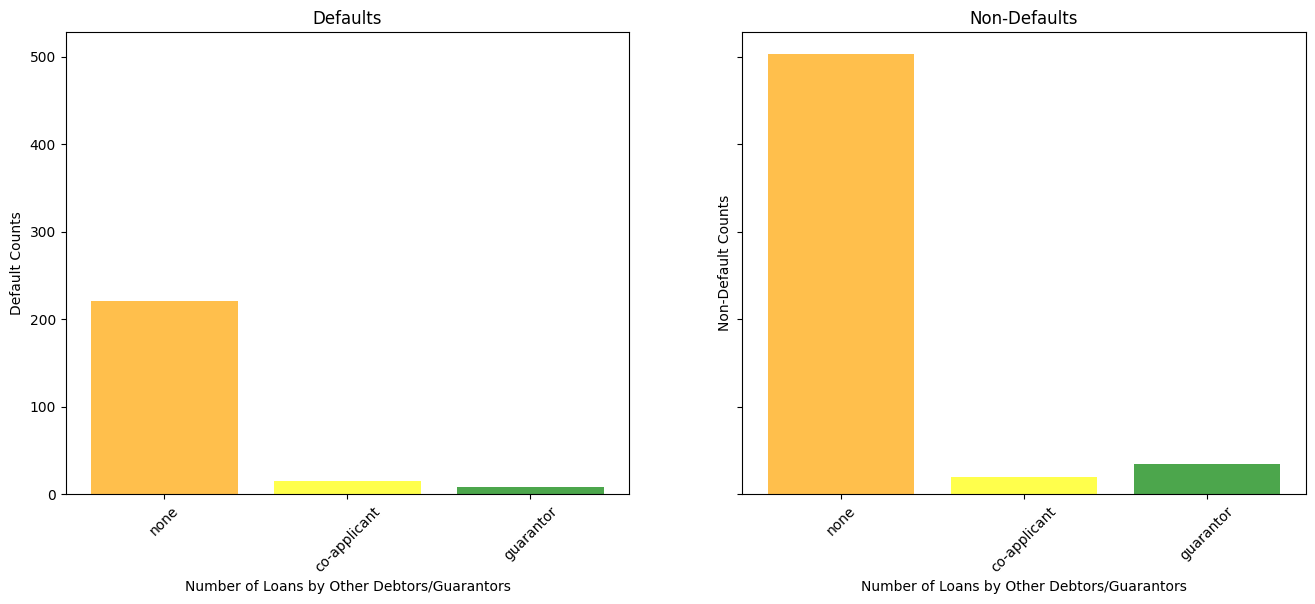

P(default|A101): 0.30525
P(non-default|A101): 0.69475
P(default|A102): 0.44118
P(non-default|A102): 0.55882
P(default|A103): 0.19048
P(non-default|A103): 0.80952


In [22]:
plot_categorical_bar(
    default_df=default_df,
    non_default_df=non_default_df,
    feature='Other_Debtors_Guarantors',
    xticks=['A101', 'A102', 'A103'],
    xticklabels=[
        'none', 'co-applicant', 'guarantor'
    ],
    label='Number of Loans by Other Debtors/Guarantors',
    colors=['orange', 'yellow', 'green']
)

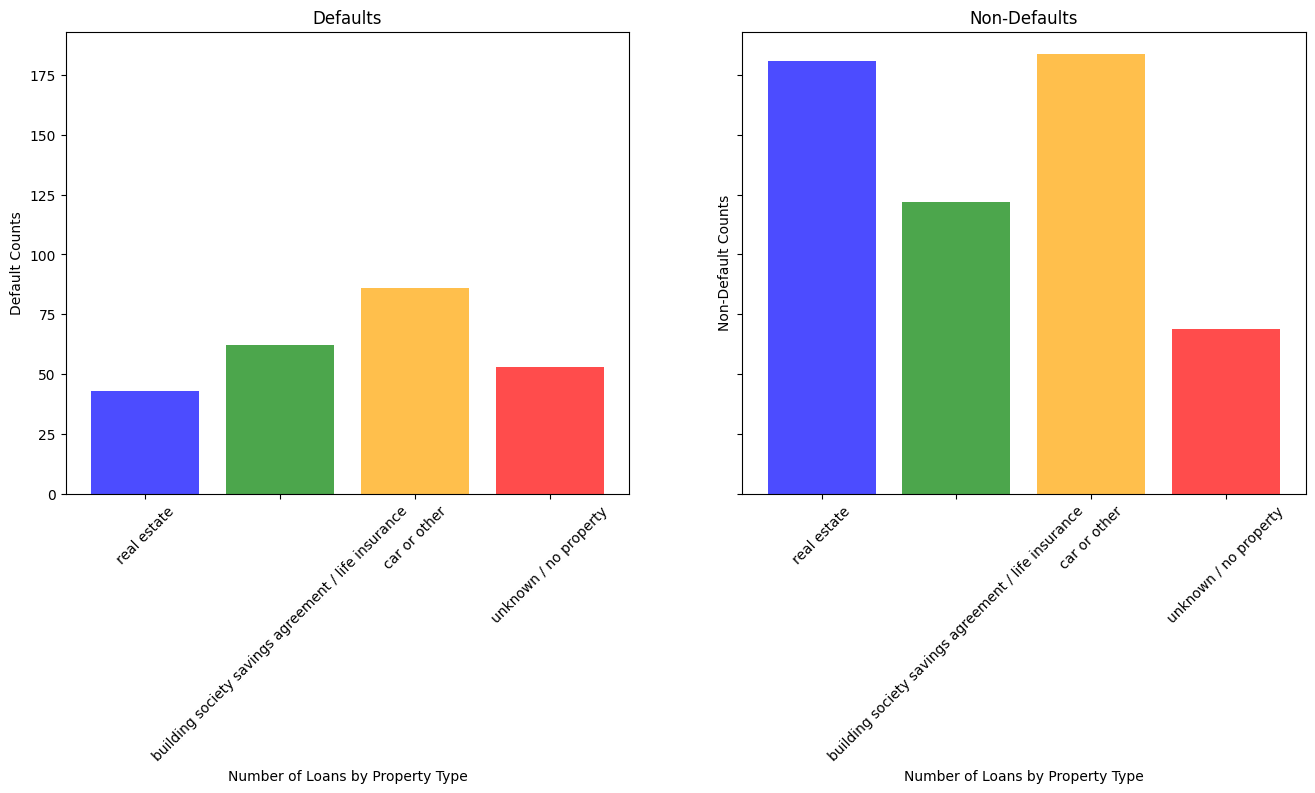

P(default|A121): 0.19196
P(non-default|A121): 0.80804
P(default|A122): 0.33696
P(non-default|A122): 0.66304
P(default|A123): 0.31852
P(non-default|A123): 0.68148
P(default|A124): 0.43443
P(non-default|A124): 0.56557


In [23]:
plot_categorical_bar(
    default_df=default_df,
    non_default_df=non_default_df,
    feature='Owned_Property',
    xticks=['A121', 'A122', 'A123', 'A124'],
    xticklabels=[
        'real estate', 'building society savings agreement / life insurance',
        'car or other', 'unknown / no property'
    ],
    label='Number of Loans by Property Type',
    colors=['blue', 'green', 'orange', 'red']
)

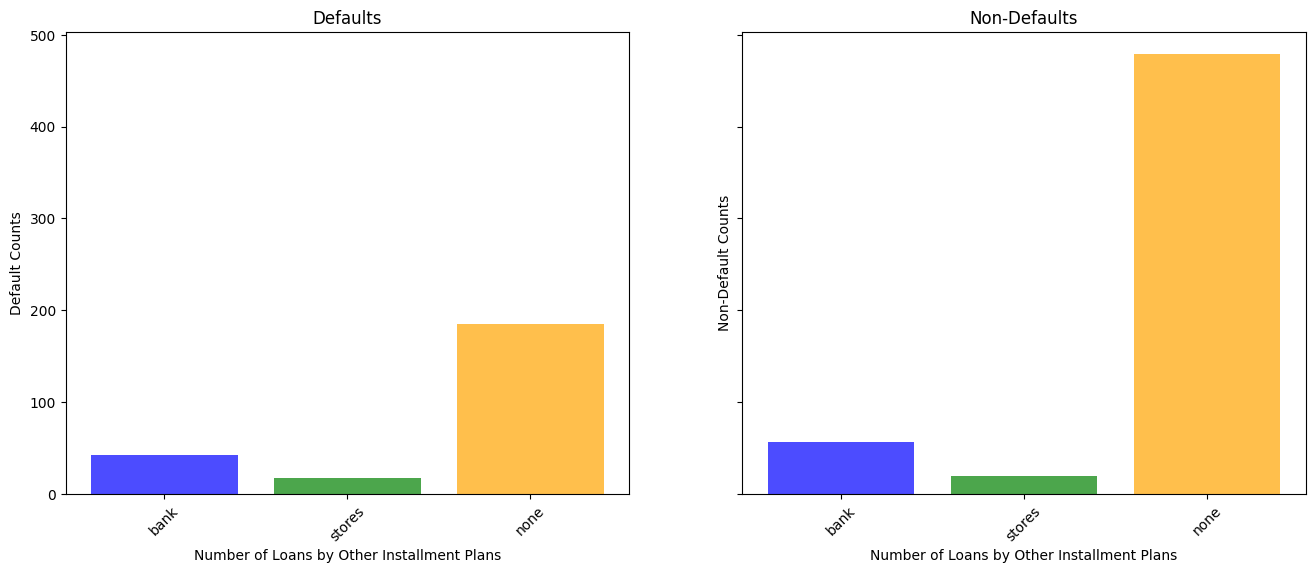

P(default|A141): 0.42424
P(non-default|A141): 0.57576
P(default|A142): 0.45946
P(non-default|A142): 0.54054
P(default|A143): 0.27861
P(non-default|A143): 0.72139


In [24]:
plot_categorical_bar(
    default_df=default_df,
    non_default_df=non_default_df,
    feature='Other_Installment_Plans',
    xticks=['A141', 'A142', 'A143'],
    xticklabels=[
        'bank', 'stores', 'none'
    ],
    label='Number of Loans by Other Installment Plans',
    colors=['blue', 'green', 'orange']
)

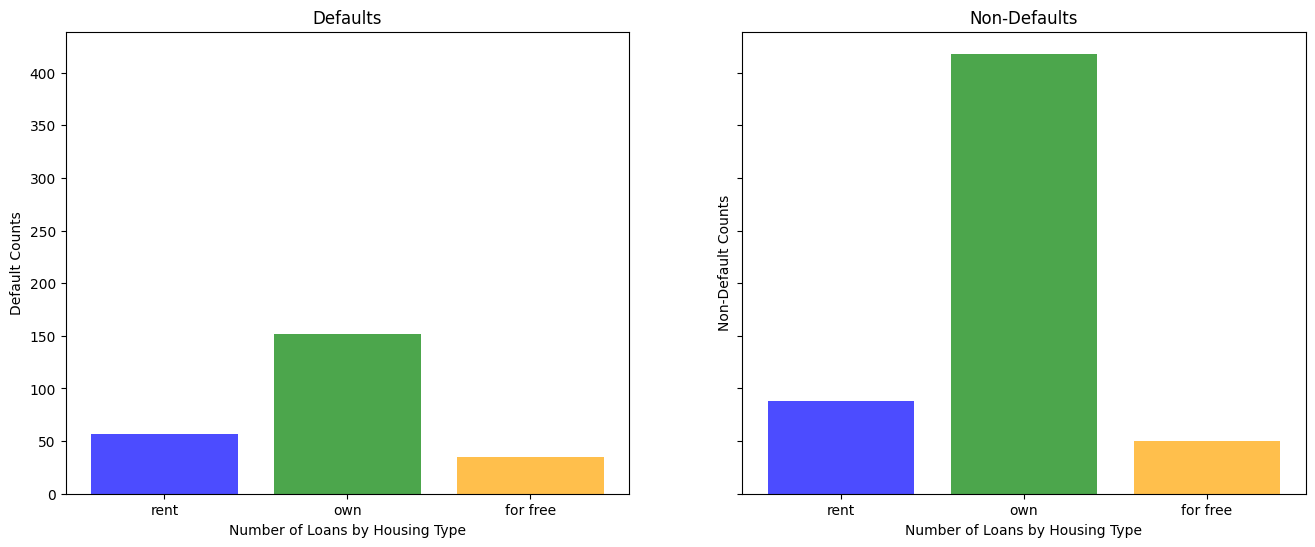

P(default|A151): 0.39310
P(non-default|A151): 0.60690
P(default|A152): 0.26667
P(non-default|A152): 0.73333
P(default|A153): 0.41176
P(non-default|A153): 0.58824


In [25]:
plot_categorical_bar(
    default_df=default_df,
    non_default_df=non_default_df,
    feature='Housing_Type',
    xticks=['A151', 'A152', 'A153'],
    xticklabels=[
        'rent', 'own', 'for free'
    ],
    label='Number of Loans by Housing Type',
    colors=['blue', 'green', 'orange'],
    rotation=0
)

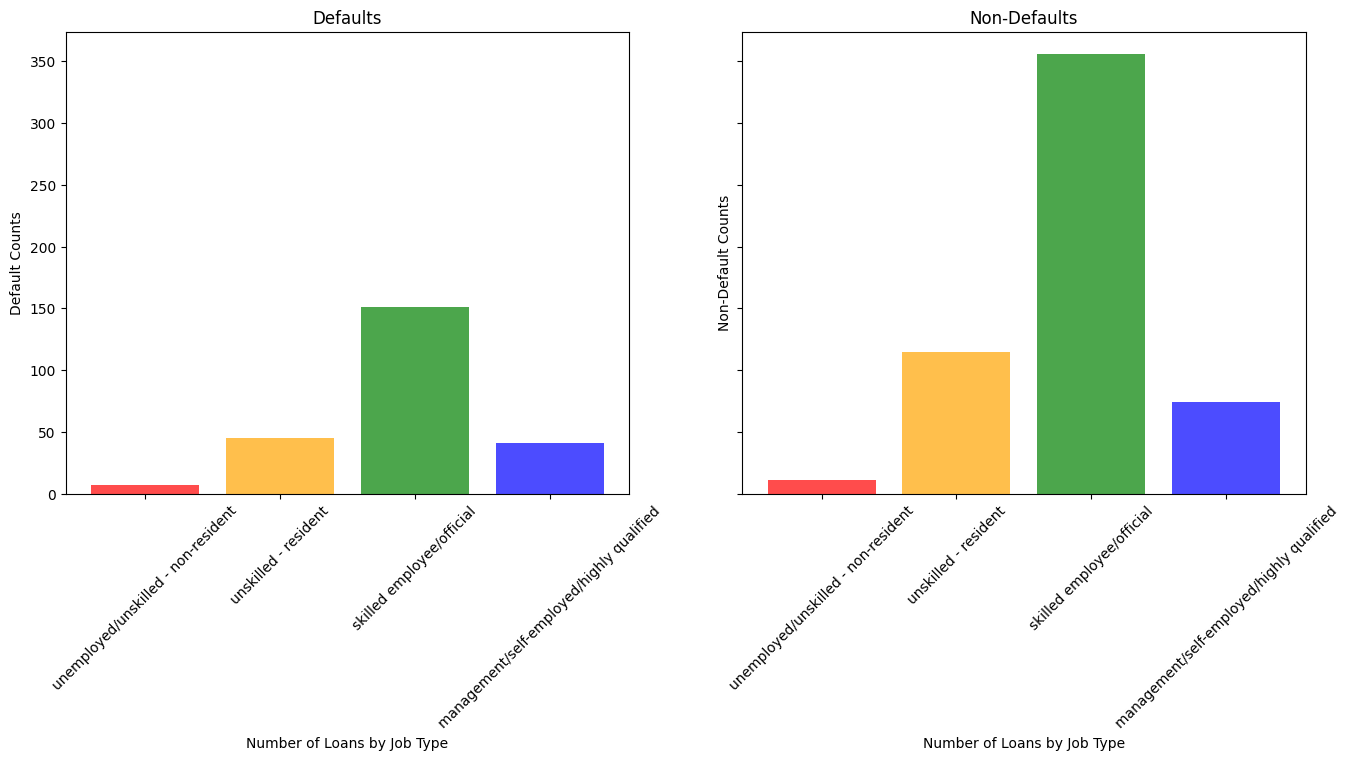

P(default|A171): 0.38889
P(non-default|A171): 0.61111
P(default|A172): 0.28125
P(non-default|A172): 0.71875
P(default|A173): 0.29783
P(non-default|A173): 0.70217
P(default|A174): 0.35652
P(non-default|A174): 0.64348


In [26]:
plot_categorical_bar(
    default_df=default_df,
    non_default_df=non_default_df,
    feature='Job_Type',
    xticks=['A171', 'A172', 'A173', 'A174'],
    xticklabels=[
        'unemployed/unskilled - non-resident', 'unskilled - resident',
        'skilled employee/official', 'management/self-employed/highly qualified'
    ],
    label='Number of Loans by Job Type',
    colors=['red', 'orange', 'green', 'blue']
)

In [27]:
def corr_matrix(data, is_numeric=True):
  corr = data.corr() if is_numeric else data


  mask = np.triu(np.ones_like(corr, dtype=bool))

  cmap = sns.diverging_palette(250, 15, as_cmap=True)

  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
              square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

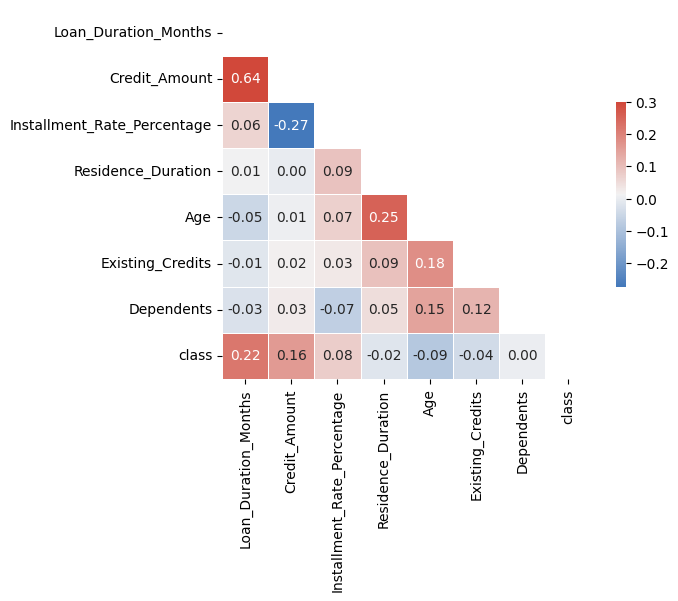

In [28]:
corr_matrix(train_df[num_columns + ['class']])

In [29]:
cat_columns.append('Age_Cat')
train_df['Age_Cat'] = pd.cut(train_df['Age'].values.flatten(), bins=[0, 25, 35, 45, 55, 65, float('INF')], labels=['(0, 25]', '[26, 35)', '[35, 45)', '[45, 55)', '[55, 65)', '[65, .)']).astype('str').reshape(-1, 1)

In [30]:
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    r, k = contingency_table.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

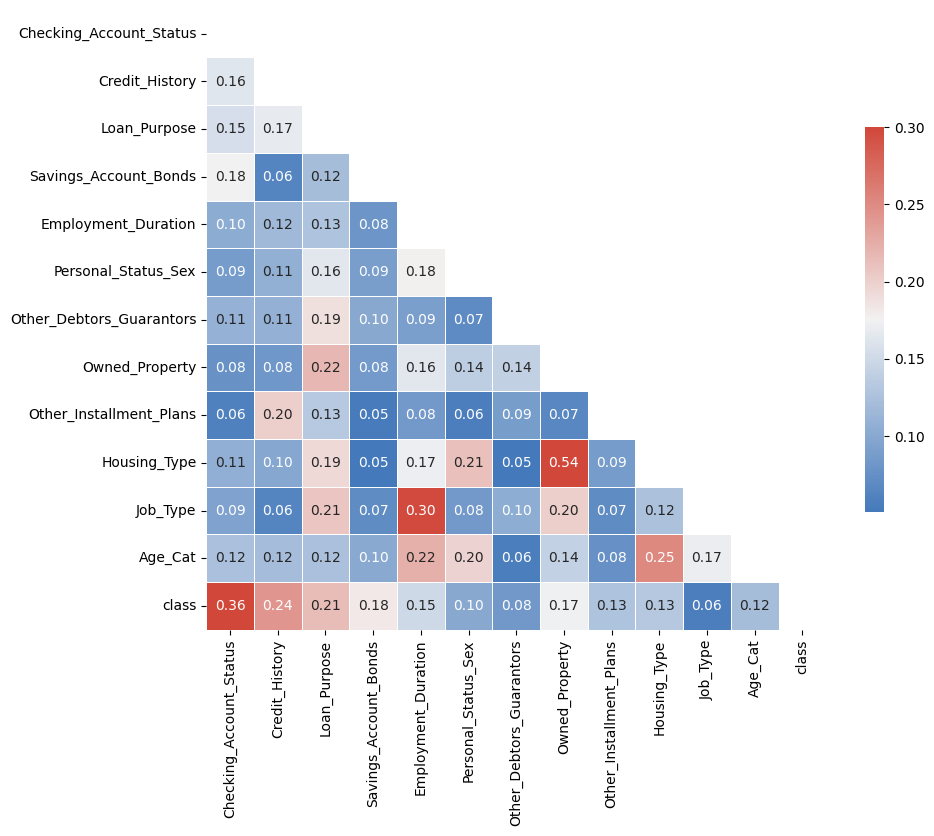

In [58]:
corr_columns = cat_columns + ['class']
dataplot = pd.DataFrame(index=corr_columns, columns=corr_columns)
for i in corr_columns:
  for j in corr_columns:
    dataplot.loc[i, j] = cramers_v(train_df[i], train_df[j])

dataplot = dataplot.astype(float)
plt.figure(figsize=(10, 10))
corr_matrix(dataplot, is_numeric=False)

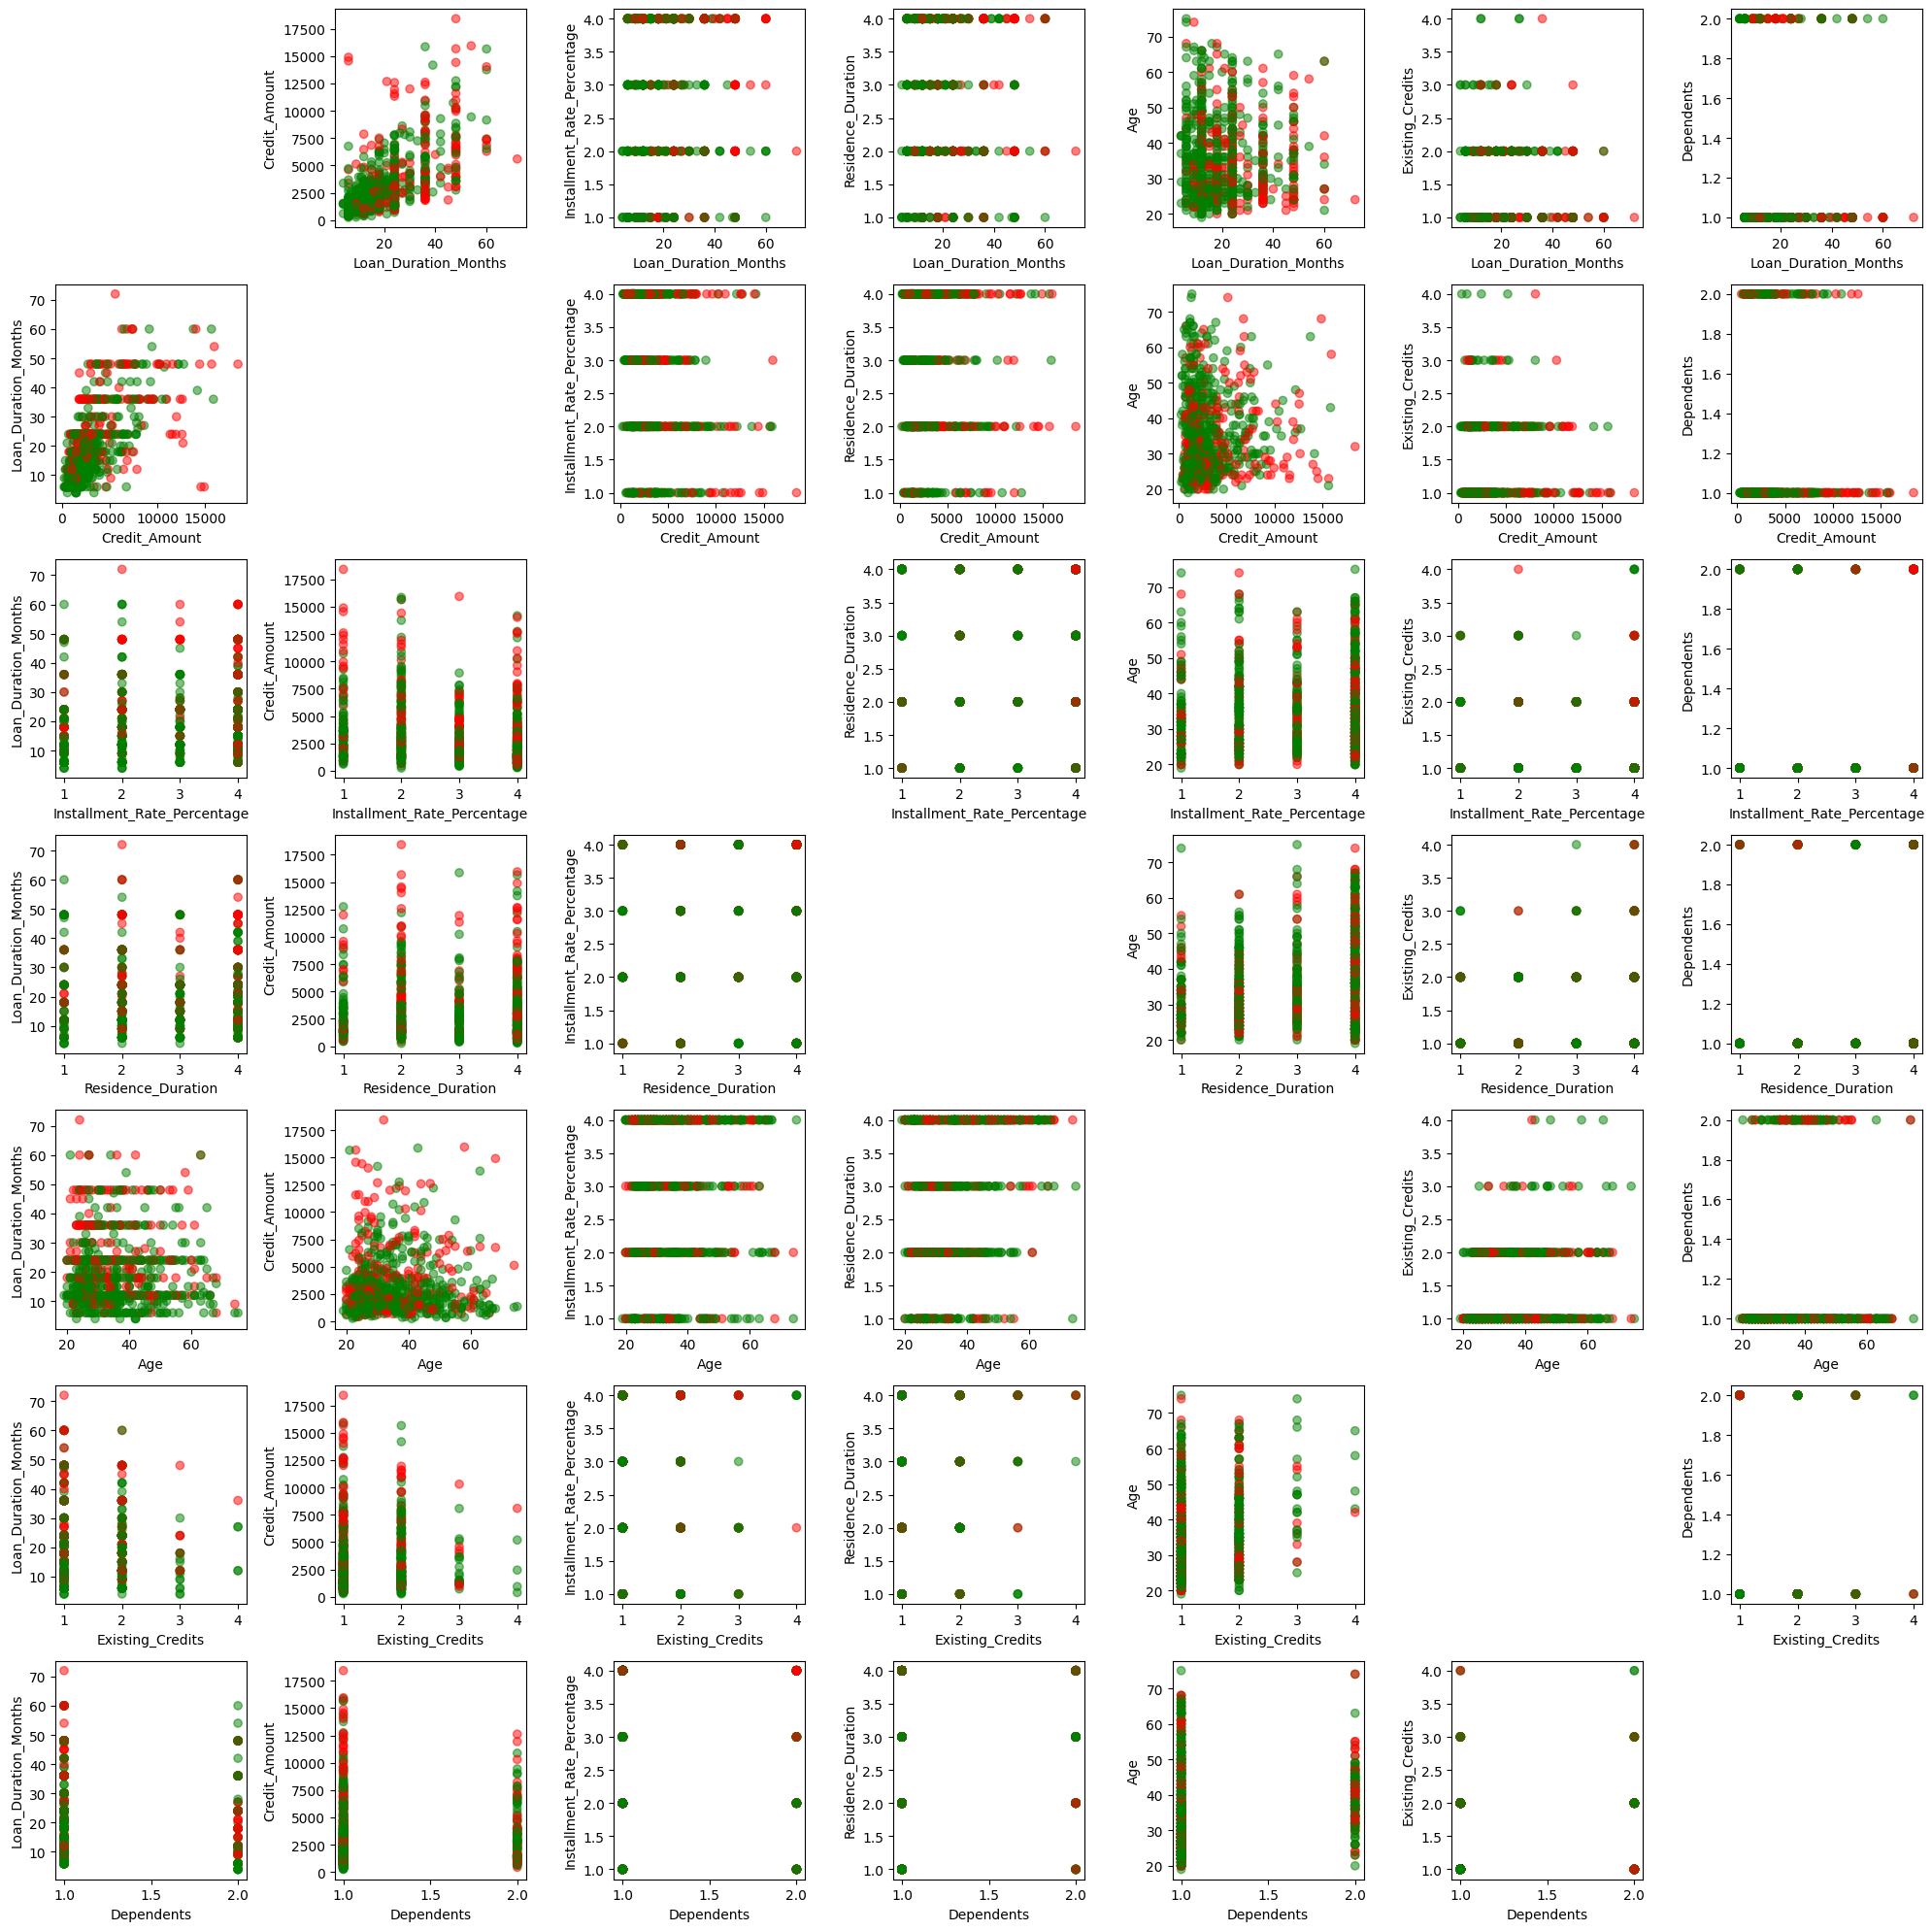

In [32]:
fig, axs = plt.subplots(len(num_columns), len(num_columns), figsize=(20, 20))

for i in range(len(num_columns)):
    for j in range(len(num_columns)):
        if i != j:
            axs[i][j].scatter(train_df[num_columns[i]], train_df[num_columns[j]],
                              c=train_df['class'].map({1: 'green', 2: 'red'}), alpha=0.5)
            axs[i][j].set_xlabel(num_columns[i])
            axs[i][j].set_ylabel(num_columns[j])
        else:
            axs[i][j].set_visible(False)

plt.tight_layout()
plt.show()

In [33]:
class KFoldTargetEncoderTrain(BaseEstimator,
                               TransformerMixin):
    def __init__(self,colnames,targetName,
                  n_fold=5, verbosity=True,
                  discardOriginal_col=False):
        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)
        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold,
                   shuffle = True, random_state=2019)
        col_mean_name = 'kfoldtragetencoder_' + self.colnames.replace('remainder__', '')
        X[col_mean_name] = np.nan
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            X.loc[X.index[val_ind], col_mean_name] = \
            X_val[self.colnames].map(X_tr.groupby(self.colnames)
                                     [self.targetName].mean())
            X[col_mean_name].fillna(mean_of_target, inplace = True)
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
        return X
    
def kfold_transform_cols(X, columns: list):
    for col in columns:
        X = KFoldTargetEncoderTrain('remainder__' + col, targetName='remainder__class').fit_transform(X)
    X.drop(columns=['remainder__' + col for col in columns], inplace=True)
    return X

In [34]:
ohe_norm_col_transformer = make_column_transformer((OneHotEncoder(sparse_output=False), cat_columns),
                                               (StandardScaler(), num_columns),
                                               remainder='passthrough').set_output(transform='pandas')
ohe_norm_df = ohe_norm_col_transformer.fit_transform(train_df).rename(columns=lambda x: re.sub('remainder__','',x))

ohe_minmax_col_transformer = make_column_transformer((OneHotEncoder(sparse_output=False), cat_columns),
                                                     (MinMaxScaler(), num_columns),
                                                     remainder='passthrough').set_output(transform='pandas')
ohe_minmax_df = ohe_minmax_col_transformer.fit_transform(train_df).rename(columns=lambda x: re.sub('remainder__','',x))

ordianl_categories = [['A11', 'A14', 'A12', 'A13'],
                      ['A34', 'A33', 'A32', 'A31', 'A30'],
                      ['A61', 'A62', 'A65', 'A63', 'A64'],
                      ['A71', 'A72', 'A73', 'A74', 'A75'],
                      ['A171', 'A172', 'A173', 'A174'],
                      ['A153', 'A151', 'A152'],
                      ['A124', 'A123', 'A122', 'A121']]
ordinal_features = ['Checking_Account_Status',
                    'Credit_History',
                    'Savings_Account_Bonds',
                    'Employment_Duration',
                    'Job_Type',
                    'Housing_Type',
                    'Owned_Property']
one_hot_features = [feature for feature in cat_columns if feature not in ordinal_features]

ord_ohe_norm_col_transformer = make_column_transformer((OrdinalEncoder(categories=ordianl_categories), ordinal_features),
                                                   (OneHotEncoder(sparse_output=False), one_hot_features),
                                                    (StandardScaler(), num_columns), remainder='passthrough').set_output(transform='pandas')
ord_ohe_norm_df = ord_ohe_norm_col_transformer.fit_transform(train_df).rename(columns=lambda x: re.sub('remainder__','',x))

ord_ohe_minmax_col_transformer = make_column_transformer((OrdinalEncoder(categories=ordianl_categories), ordinal_features),
                                                     (OneHotEncoder(sparse_output=False), one_hot_features),
                                                    (MinMaxScaler(), num_columns), remainder='passthrough').set_output(transform='pandas')
ord_ohe_minmax_df = ord_ohe_minmax_col_transformer.fit_transform(train_df).rename(columns=lambda x: re.sub('remainder__','',x))

ord_kfold_norm_col_transformer = make_column_transformer((OrdinalEncoder(categories=ordianl_categories), ordinal_features),
                                                         (StandardScaler(), num_columns), remainder='passthrough').set_output(transform='pandas')
ord_kfold_norm_df = kfold_transform_cols(ord_kfold_norm_col_transformer.fit_transform(train_df), one_hot_features).rename(columns=lambda x: re.sub('remainder__','',x))

ord_kfold_minmax_col_transformer = make_column_transformer((OrdinalEncoder(categories=ordianl_categories), ordinal_features),
                                                           (MinMaxScaler(), num_columns), remainder='passthrough').set_output(transform='pandas')
ord_kfold_minmax_df = kfold_transform_cols(ord_kfold_minmax_col_transformer.fit_transform(train_df), one_hot_features).rename(columns=lambda x: re.sub('remainder__','',x))

In [35]:
ohe_norm_df.head()

,onehotencoder__Checking_Account_Status_A11,onehotencoder__Checking_Account_Status_A12,onehotencoder__Checking_Account_Status_A13,onehotencoder__Checking_Account_Status_A14,onehotencoder__Credit_History_A30,onehotencoder__Credit_History_A31,onehotencoder__Credit_History_A32,onehotencoder__Credit_History_A33,onehotencoder__Credit_History_A34,onehotencoder__Loan_Purpose_A40,...,standardscaler__Loan_Duration_Months,standardscaler__Credit_Amount,standardscaler__Installment_Rate_Percentage,standardscaler__Residence_Duration,standardscaler__Age,standardscaler__Existing_Credits,standardscaler__Dependents,Has_Telephone,Foreign_Worker,class
675,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.741200,0.456523,0.927558,1.048565,-0.846269,-0.692327,-0.420084,1,1,1
358,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.727330,-0.875585,0.927558,-0.786997,-0.670238,-0.692327,-0.420084,0,1,1
159,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-1.216841,-0.477443,-1.741674,-0.786997,-0.142145,1.027741,2.380476,0,1,1
533,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.251690,-0.685740,0.927558,0.130784,-0.846269,-0.692327,-0.420084,1,1,1
678,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.251690,-0.304986,0.927558,1.048565,2.498320,-0.692327,-0.420084,0,1,1


In [36]:
ohe_minmax_df.head()

,onehotencoder__Checking_Account_Status_A11,onehotencoder__Checking_Account_Status_A12,onehotencoder__Checking_Account_Status_A13,onehotencoder__Checking_Account_Status_A14,onehotencoder__Credit_History_A30,onehotencoder__Credit_History_A31,onehotencoder__Credit_History_A32,onehotencoder__Credit_History_A33,onehotencoder__Credit_History_A34,onehotencoder__Loan_Purpose_A40,...,minmaxscaler__Loan_Duration_Months,minmaxscaler__Credit_Amount,minmaxscaler__Installment_Rate_Percentage,minmaxscaler__Residence_Duration,minmaxscaler__Age,minmaxscaler__Existing_Credits,minmaxscaler__Dependents,Has_Telephone,Foreign_Worker,class
675,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.382353,0.235501,1.0,1.000000,0.125000,0.000000,0.0,1,1,1
358,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.117647,0.028942,1.0,0.333333,0.160714,0.000000,0.0,0,1,1
159,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.029412,0.090679,0.0,0.333333,0.267857,0.333333,1.0,0,1,1
533,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.294118,0.058380,1.0,0.666667,0.125000,0.000000,0.0,1,1,1
678,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.294118,0.117420,1.0,1.000000,0.803571,0.000000,0.0,0,1,1


In [37]:
ord_ohe_norm_df.head()

,ordinalencoder__Checking_Account_Status,ordinalencoder__Credit_History,ordinalencoder__Savings_Account_Bonds,ordinalencoder__Employment_Duration,ordinalencoder__Job_Type,ordinalencoder__Housing_Type,ordinalencoder__Owned_Property,onehotencoder__Loan_Purpose_A40,onehotencoder__Loan_Purpose_A41,onehotencoder__Loan_Purpose_A410,...,standardscaler__Loan_Duration_Months,standardscaler__Credit_Amount,standardscaler__Installment_Rate_Percentage,standardscaler__Residence_Duration,standardscaler__Age,standardscaler__Existing_Credits,standardscaler__Dependents,Has_Telephone,Foreign_Worker,class
675,1.0,0.0,0.0,3.0,3.0,1.0,1.0,0.0,0.0,0.0,...,0.741200,0.456523,0.927558,1.048565,-0.846269,-0.692327,-0.420084,1,1,1
358,1.0,2.0,0.0,2.0,2.0,2.0,3.0,0.0,0.0,0.0,...,-0.727330,-0.875585,0.927558,-0.786997,-0.670238,-0.692327,-0.420084,0,1,1
159,1.0,0.0,2.0,2.0,1.0,2.0,3.0,0.0,0.0,0.0,...,-1.216841,-0.477443,-1.741674,-0.786997,-0.142145,1.027741,2.380476,0,1,1
533,1.0,2.0,1.0,3.0,2.0,2.0,2.0,0.0,0.0,0.0,...,0.251690,-0.685740,0.927558,0.130784,-0.846269,-0.692327,-0.420084,1,1,1
678,0.0,2.0,0.0,4.0,1.0,1.0,3.0,0.0,0.0,0.0,...,0.251690,-0.304986,0.927558,1.048565,2.498320,-0.692327,-0.420084,0,1,1


In [38]:
ord_ohe_minmax_df.head()

,ordinalencoder__Checking_Account_Status,ordinalencoder__Credit_History,ordinalencoder__Savings_Account_Bonds,ordinalencoder__Employment_Duration,ordinalencoder__Job_Type,ordinalencoder__Housing_Type,ordinalencoder__Owned_Property,onehotencoder__Loan_Purpose_A40,onehotencoder__Loan_Purpose_A41,onehotencoder__Loan_Purpose_A410,...,minmaxscaler__Loan_Duration_Months,minmaxscaler__Credit_Amount,minmaxscaler__Installment_Rate_Percentage,minmaxscaler__Residence_Duration,minmaxscaler__Age,minmaxscaler__Existing_Credits,minmaxscaler__Dependents,Has_Telephone,Foreign_Worker,class
675,1.0,0.0,0.0,3.0,3.0,1.0,1.0,0.0,0.0,0.0,...,0.382353,0.235501,1.0,1.000000,0.125000,0.000000,0.0,1,1,1
358,1.0,2.0,0.0,2.0,2.0,2.0,3.0,0.0,0.0,0.0,...,0.117647,0.028942,1.0,0.333333,0.160714,0.000000,0.0,0,1,1
159,1.0,0.0,2.0,2.0,1.0,2.0,3.0,0.0,0.0,0.0,...,0.029412,0.090679,0.0,0.333333,0.267857,0.333333,1.0,0,1,1
533,1.0,2.0,1.0,3.0,2.0,2.0,2.0,0.0,0.0,0.0,...,0.294118,0.058380,1.0,0.666667,0.125000,0.000000,0.0,1,1,1
678,0.0,2.0,0.0,4.0,1.0,1.0,3.0,0.0,0.0,0.0,...,0.294118,0.117420,1.0,1.000000,0.803571,0.000000,0.0,0,1,1


In [39]:
ord_kfold_norm_df.head()

,ordinalencoder__Checking_Account_Status,ordinalencoder__Credit_History,ordinalencoder__Savings_Account_Bonds,ordinalencoder__Employment_Duration,ordinalencoder__Job_Type,ordinalencoder__Housing_Type,ordinalencoder__Owned_Property,standardscaler__Loan_Duration_Months,standardscaler__Credit_Amount,standardscaler__Installment_Rate_Percentage,...,standardscaler__Existing_Credits,standardscaler__Dependents,Has_Telephone,Foreign_Worker,class,kfoldtragetencoder_Loan_Purpose,kfoldtragetencoder_Personal_Status_Sex,kfoldtragetencoder_Other_Debtors_Guarantors,kfoldtragetencoder_Other_Installment_Plans,kfoldtragetencoder_Age_Cat
675,1.0,0.0,0.0,3.0,3.0,1.0,1.0,0.741200,0.456523,0.927558,...,-0.692327,-0.420084,1,1,1,1.225610,1.346734,1.303602,1.280303,1.323887
358,1.0,2.0,0.0,2.0,2.0,2.0,3.0,-0.727330,-0.875585,0.927558,...,-0.692327,-0.420084,0,1,1,1.206897,1.311475,1.313149,1.279330,1.312253
159,1.0,0.0,2.0,2.0,1.0,2.0,3.0,-1.216841,-0.477443,-1.741674,...,1.027741,2.380476,0,1,1,1.225610,1.274566,1.303602,1.280303,1.323887
533,1.0,2.0,1.0,3.0,2.0,2.0,2.0,0.251690,-0.685740,0.927558,...,-0.692327,-0.420084,1,1,1,1.224719,1.272727,1.290435,1.260952,1.269388
678,0.0,2.0,0.0,4.0,1.0,1.0,3.0,0.251690,-0.304986,0.927558,...,-0.692327,-0.420084,0,1,1,1.206897,1.277286,1.313149,1.456790,1.242424


In [40]:
ord_kfold_minmax_df.head()

,ordinalencoder__Checking_Account_Status,ordinalencoder__Credit_History,ordinalencoder__Savings_Account_Bonds,ordinalencoder__Employment_Duration,ordinalencoder__Job_Type,ordinalencoder__Housing_Type,ordinalencoder__Owned_Property,minmaxscaler__Loan_Duration_Months,minmaxscaler__Credit_Amount,minmaxscaler__Installment_Rate_Percentage,...,minmaxscaler__Existing_Credits,minmaxscaler__Dependents,Has_Telephone,Foreign_Worker,class,kfoldtragetencoder_Loan_Purpose,kfoldtragetencoder_Personal_Status_Sex,kfoldtragetencoder_Other_Debtors_Guarantors,kfoldtragetencoder_Other_Installment_Plans,kfoldtragetencoder_Age_Cat
675,1.0,0.0,0.0,3.0,3.0,1.0,1.0,0.382353,0.235501,1.0,...,0.000000,0.0,1,1,1,1.225610,1.346734,1.303602,1.280303,1.323887
358,1.0,2.0,0.0,2.0,2.0,2.0,3.0,0.117647,0.028942,1.0,...,0.000000,0.0,0,1,1,1.206897,1.311475,1.313149,1.279330,1.312253
159,1.0,0.0,2.0,2.0,1.0,2.0,3.0,0.029412,0.090679,0.0,...,0.333333,1.0,0,1,1,1.225610,1.274566,1.303602,1.280303,1.323887
533,1.0,2.0,1.0,3.0,2.0,2.0,2.0,0.294118,0.058380,1.0,...,0.000000,0.0,1,1,1,1.224719,1.272727,1.290435,1.260952,1.269388
678,0.0,2.0,0.0,4.0,1.0,1.0,3.0,0.294118,0.117420,1.0,...,0.000000,0.0,0,1,1,1.206897,1.277286,1.313149,1.456790,1.242424


In [41]:
def get_models():
    models = {
        'LR': LogisticRegression(),
        'LDA': LinearDiscriminantAnalysis(),
        'KNN': KNeighborsClassifier(),
        'DT': DecisionTreeClassifier(),
        'NB': GaussianNB(),
        'SVM': SVC(probability=True),
        'AB': AdaBoostClassifier(),
        'GBM': GradientBoostingClassifier(),
        'RF': RandomForestClassifier()
    }
    return models

<h3>Forward Selection<h3>

In [42]:
def forward_selection(df: pd.DataFrame, model, target:str, log=False, split=True) -> tuple: # returns eval score and subset
    X, y = df.drop(columns=target), df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
    max_score = 0
    chosen_features = []
    i = 0
    while i < len(df.columns):
        if df.columns[i] == 'class':
            i += 1
            continue
        new_cols = []
        if df.columns[i].startswith("onehotencoder") and split:
            new_cols.append(df.columns[i])
            i += 1
            feature_name = "".join(df.columns[i].split("_")[2:-1])
            while True:
                if i >= len(df.columns) or not df.columns[i].startswith("onehotencoder") or "".join(df.columns[i].split("_")[2:-1]) != feature_name:
                    break
                new_cols.append(df.columns[i])
                i += 1
            i -= 1
        else:
            new_cols.append(df.columns[i])

        model.fit(X_train[chosen_features + new_cols], y_train)
        y_pred = model.predict(X_test[chosen_features + new_cols])
        score = f1_score(y_test, y_pred)
        if log:
            print(f'f1 score for {new_cols} using {type(model).__name__} is {score:5f}')
        if score > max_score:
            max_score = score
            chosen_features += new_cols
        i += 1
    return (max_score, chosen_features)

***One-hot* encoding of categorical features and *standard* scaling of numerical features:**

In [43]:
for name, model in get_models().items():
    score, features = forward_selection(ohe_norm_df, model, 'class')
    print(f'model: {name}, best score: {score:5f}, best features: ', features)

model: LR, best score: 0.873950, best features:  ['onehotencoder__Checking_Account_Status_A11', 'onehotencoder__Checking_Account_Status_A12', 'onehotencoder__Checking_Account_Status_A13', 'onehotencoder__Checking_Account_Status_A14', 'onehotencoder__Credit_History_A30', 'onehotencoder__Credit_History_A31', 'onehotencoder__Credit_History_A32', 'onehotencoder__Credit_History_A33', 'onehotencoder__Credit_History_A34', 'onehotencoder__Loan_Purpose_A40', 'onehotencoder__Loan_Purpose_A41', 'onehotencoder__Loan_Purpose_A410', 'onehotencoder__Loan_Purpose_A42', 'onehotencoder__Loan_Purpose_A43', 'onehotencoder__Loan_Purpose_A44', 'onehotencoder__Loan_Purpose_A45', 'onehotencoder__Loan_Purpose_A46', 'onehotencoder__Loan_Purpose_A48', 'onehotencoder__Loan_Purpose_A49', 'onehotencoder__Savings_Account_Bonds_A61', 'onehotencoder__Savings_Account_Bonds_A62', 'onehotencoder__Savings_Account_Bonds_A63', 'onehotencoder__Savings_Account_Bonds_A64', 'onehotencoder__Savings_Account_Bonds_A65', 'onehotenc

**One-hot encoding of categorical features and minmax scaling of numerical features:**

In [44]:
for name, model in get_models().items():
    score, features = forward_selection(ohe_minmax_df, model, 'class')
    print(f'model: {name}, best score: {score:5f}, best features: ', features)

model: LR, best score: 0.873950, best features:  ['onehotencoder__Checking_Account_Status_A11', 'onehotencoder__Checking_Account_Status_A12', 'onehotencoder__Checking_Account_Status_A13', 'onehotencoder__Checking_Account_Status_A14', 'onehotencoder__Credit_History_A30', 'onehotencoder__Credit_History_A31', 'onehotencoder__Credit_History_A32', 'onehotencoder__Credit_History_A33', 'onehotencoder__Credit_History_A34', 'onehotencoder__Loan_Purpose_A40', 'onehotencoder__Loan_Purpose_A41', 'onehotencoder__Loan_Purpose_A410', 'onehotencoder__Loan_Purpose_A42', 'onehotencoder__Loan_Purpose_A43', 'onehotencoder__Loan_Purpose_A44', 'onehotencoder__Loan_Purpose_A45', 'onehotencoder__Loan_Purpose_A46', 'onehotencoder__Loan_Purpose_A48', 'onehotencoder__Loan_Purpose_A49', 'onehotencoder__Savings_Account_Bonds_A61', 'onehotencoder__Savings_Account_Bonds_A62', 'onehotencoder__Savings_Account_Bonds_A63', 'onehotencoder__Savings_Account_Bonds_A64', 'onehotencoder__Savings_Account_Bonds_A65', 'onehotenc

**Ordinal/one-hot encoding of categorical features and standard scaling of numerical features:**

In [45]:
for name, model in get_models().items():
    score, features = forward_selection(ord_ohe_norm_df, model, 'class')
    print(f'model: {name}, best score: {score:5f}, best features: ', features)

model: LR, best score: 0.872000, best features:  ['ordinalencoder__Checking_Account_Status', 'ordinalencoder__Credit_History', 'ordinalencoder__Savings_Account_Bonds', 'ordinalencoder__Employment_Duration', 'ordinalencoder__Housing_Type', 'standardscaler__Credit_Amount', 'standardscaler__Installment_Rate_Percentage', 'standardscaler__Age', 'Has_Telephone']
model: LDA, best score: 0.872000, best features:  ['ordinalencoder__Checking_Account_Status', 'ordinalencoder__Credit_History', 'ordinalencoder__Savings_Account_Bonds', 'ordinalencoder__Employment_Duration', 'ordinalencoder__Housing_Type', 'standardscaler__Credit_Amount', 'standardscaler__Installment_Rate_Percentage', 'standardscaler__Age', 'Has_Telephone']
model: KNN, best score: 0.860656, best features:  ['ordinalencoder__Checking_Account_Status', 'ordinalencoder__Credit_History', 'ordinalencoder__Savings_Account_Bonds', 'ordinalencoder__Job_Type', 'ordinalencoder__Owned_Property', 'onehotencoder__Loan_Purpose_A40', 'onehotencoder_

***Ordinal/one-hot* encoding of categorical features and *minmax* scaling of numerical features:**

In [46]:
for name, model in get_models().items():
    score, features = forward_selection(ord_ohe_minmax_df, model, 'class')
    print(f'model: {name}, best score: {score:5f}, best features: ', features)

model: LR, best score: 0.869565, best features:  ['ordinalencoder__Checking_Account_Status', 'ordinalencoder__Credit_History', 'ordinalencoder__Savings_Account_Bonds', 'ordinalencoder__Employment_Duration', 'ordinalencoder__Housing_Type', 'minmaxscaler__Credit_Amount', 'minmaxscaler__Installment_Rate_Percentage', 'minmaxscaler__Existing_Credits']
model: LDA, best score: 0.872000, best features:  ['ordinalencoder__Checking_Account_Status', 'ordinalencoder__Credit_History', 'ordinalencoder__Savings_Account_Bonds', 'ordinalencoder__Employment_Duration', 'ordinalencoder__Housing_Type', 'minmaxscaler__Credit_Amount', 'minmaxscaler__Installment_Rate_Percentage', 'minmaxscaler__Age', 'Has_Telephone']
model: KNN, best score: 0.866953, best features:  ['ordinalencoder__Checking_Account_Status', 'ordinalencoder__Credit_History', 'ordinalencoder__Savings_Account_Bonds', 'ordinalencoder__Job_Type', 'ordinalencoder__Owned_Property', 'onehotencoder__Loan_Purpose_A40', 'onehotencoder__Loan_Purpose_A4

***Ordinal/kfold* encoding of categorical features and *standard* scaling of numerical features:**

In [47]:
for name, model in get_models().items():
    score, features = forward_selection(ord_kfold_norm_df, model, 'class')
    print(f'model: {name}, best score: {score:5f}, best features: ', features)

model: LR, best score: 0.875502, best features:  ['ordinalencoder__Checking_Account_Status', 'ordinalencoder__Credit_History', 'ordinalencoder__Savings_Account_Bonds', 'ordinalencoder__Employment_Duration', 'ordinalencoder__Housing_Type', 'standardscaler__Credit_Amount', 'standardscaler__Installment_Rate_Percentage', 'standardscaler__Age', 'Has_Telephone', 'kfoldtragetencoder_Loan_Purpose']
model: LDA, best score: 0.875502, best features:  ['ordinalencoder__Checking_Account_Status', 'ordinalencoder__Credit_History', 'ordinalencoder__Savings_Account_Bonds', 'ordinalencoder__Employment_Duration', 'ordinalencoder__Housing_Type', 'standardscaler__Credit_Amount', 'standardscaler__Installment_Rate_Percentage', 'standardscaler__Age', 'Has_Telephone', 'kfoldtragetencoder_Age_Cat']
model: KNN, best score: 0.858369, best features:  ['ordinalencoder__Checking_Account_Status', 'ordinalencoder__Credit_History', 'ordinalencoder__Savings_Account_Bonds', 'ordinalencoder__Job_Type', 'ordinalencoder__Ow

***Ordinal/kfold* encoding of categorical features and *minmax* scaling of numerical features:**

In [48]:
for name, model in get_models().items():
    score, features = forward_selection(ord_kfold_minmax_df, model, 'class')
    print(f'model: {name}, best score: {score:5f}, best features: ', features)

model: LR, best score: 0.869565, best features:  ['ordinalencoder__Checking_Account_Status', 'ordinalencoder__Credit_History', 'ordinalencoder__Savings_Account_Bonds', 'ordinalencoder__Employment_Duration', 'ordinalencoder__Housing_Type', 'minmaxscaler__Credit_Amount', 'minmaxscaler__Installment_Rate_Percentage', 'minmaxscaler__Existing_Credits']
model: LDA, best score: 0.875502, best features:  ['ordinalencoder__Checking_Account_Status', 'ordinalencoder__Credit_History', 'ordinalencoder__Savings_Account_Bonds', 'ordinalencoder__Employment_Duration', 'ordinalencoder__Housing_Type', 'minmaxscaler__Credit_Amount', 'minmaxscaler__Installment_Rate_Percentage', 'minmaxscaler__Age', 'Has_Telephone', 'kfoldtragetencoder_Age_Cat']
model: KNN, best score: 0.861925, best features:  ['ordinalencoder__Checking_Account_Status', 'ordinalencoder__Credit_History', 'ordinalencoder__Savings_Account_Bonds', 'ordinalencoder__Job_Type', 'ordinalencoder__Owned_Property', 'minmaxscaler__Installment_Rate_Perc

<h3>Backward Elimination<h3>

In [49]:
def backward_elimination(df: pd.DataFrame, model, target:str, threshold=15) -> tuple: # returns eval score and subset
    X, y = df.drop(columns=target), df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

    active_features = [f for f in X.columns]
    while len(active_features) > threshold:
        elim = None
        min_score = 1
        for af in active_features:
            X_train_dummy = X_train[[a for a in active_features if a != af]]
            X_test_dummy = X_test[X_train_dummy.columns]
            model.fit(X_train_dummy, y_train)
            y_pred = model.predict(X_test_dummy)
            score = f1_score(y_test, y_pred)
            if score < min_score:
                min_score = score
                elim = af
        active_features.remove(elim)
    model.fit(X_train[[a for a in active_features]], y_train)
    y_pred = model.predict(X_test[[a for a in active_features]])
    score = f1_score(y_test, y_pred)
    return (score, active_features)

***One-hot* encoding of categorical features and *standard* scaling of numerical features:**

In [50]:
for name, model in get_models().items():
    score, features = backward_elimination(ohe_norm_df, model, 'class')
    print(f'model: {name}, best score: {score:5f}, best features: ', features)

model: LR, best score: 0.783333, best features:  ['onehotencoder__Checking_Account_Status_A12', 'onehotencoder__Loan_Purpose_A42', 'onehotencoder__Loan_Purpose_A43', 'onehotencoder__Loan_Purpose_A49', 'onehotencoder__Savings_Account_Bonds_A61', 'onehotencoder__Savings_Account_Bonds_A65', 'onehotencoder__Personal_Status_Sex_A91', 'onehotencoder__Owned_Property_A121', 'onehotencoder__Owned_Property_A123', 'onehotencoder__Other_Installment_Plans_A141', 'onehotencoder__Housing_Type_A151', 'onehotencoder__Job_Type_A174', 'onehotencoder__Age_Cat_[45, 55)', 'standardscaler__Loan_Duration_Months', 'standardscaler__Installment_Rate_Percentage']
model: LDA, best score: 0.767241, best features:  ['onehotencoder__Checking_Account_Status_A12', 'onehotencoder__Credit_History_A34', 'onehotencoder__Savings_Account_Bonds_A65', 'onehotencoder__Employment_Duration_A74', 'onehotencoder__Employment_Duration_A75', 'onehotencoder__Personal_Status_Sex_A93', 'onehotencoder__Owned_Property_A122', 'onehotencoder

**One-hot encoding of categorical features and minmax scaling of numerical features:**

In [51]:
for name, model in get_models().items():
    score, features = backward_elimination(ohe_minmax_df, model, 'class')
    print(f'model: {name}, best score: {score:5f}, best features: ', features)

model: LR, best score: 0.767241, best features:  ['onehotencoder__Checking_Account_Status_A14', 'onehotencoder__Credit_History_A34', 'onehotencoder__Loan_Purpose_A410', 'onehotencoder__Loan_Purpose_A43', 'onehotencoder__Savings_Account_Bonds_A65', 'onehotencoder__Personal_Status_Sex_A91', 'onehotencoder__Personal_Status_Sex_A93', 'onehotencoder__Owned_Property_A121', 'onehotencoder__Other_Installment_Plans_A143', 'onehotencoder__Age_Cat_(0, 25]', 'onehotencoder__Age_Cat_[26, 35)', 'onehotencoder__Age_Cat_[65, .)', 'minmaxscaler__Loan_Duration_Months', 'minmaxscaler__Credit_Amount', 'Has_Telephone']
model: LDA, best score: 0.767241, best features:  ['onehotencoder__Checking_Account_Status_A12', 'onehotencoder__Credit_History_A34', 'onehotencoder__Savings_Account_Bonds_A65', 'onehotencoder__Employment_Duration_A74', 'onehotencoder__Employment_Duration_A75', 'onehotencoder__Personal_Status_Sex_A93', 'onehotencoder__Owned_Property_A122', 'onehotencoder__Owned_Property_A123', 'onehotencoder

**Ordinal/one-hot encoding of categorical features and standard scaling of numerical features:**

In [52]:
for name, model in get_models().items():
    score, features = backward_elimination(ord_ohe_norm_df, model, 'class')
    print(f'model: {name}, best score: {score:5f}, best features: ', features)

model: LR, best score: 0.759494, best features:  ['ordinalencoder__Savings_Account_Bonds', 'ordinalencoder__Owned_Property', 'onehotencoder__Loan_Purpose_A410', 'onehotencoder__Loan_Purpose_A42', 'onehotencoder__Loan_Purpose_A43', 'onehotencoder__Loan_Purpose_A46', 'onehotencoder__Loan_Purpose_A49', 'onehotencoder__Personal_Status_Sex_A93', 'onehotencoder__Other_Installment_Plans_A142', 'onehotencoder__Other_Installment_Plans_A143', 'onehotencoder__Age_Cat_(0, 25]', 'onehotencoder__Age_Cat_[26, 35)', 'standardscaler__Loan_Duration_Months', 'standardscaler__Existing_Credits', 'Has_Telephone']
model: LDA, best score: 0.762712, best features:  ['ordinalencoder__Savings_Account_Bonds', 'ordinalencoder__Owned_Property', 'onehotencoder__Loan_Purpose_A410', 'onehotencoder__Loan_Purpose_A42', 'onehotencoder__Loan_Purpose_A43', 'onehotencoder__Loan_Purpose_A49', 'onehotencoder__Personal_Status_Sex_A93', 'onehotencoder__Other_Installment_Plans_A143', 'onehotencoder__Age_Cat_[26, 35)', 'onehotenc

***Ordinal/one-hot* encoding of categorical features and *minmax* scaling of numerical features:**

In [53]:
for name, model in get_models().items():
    score, features = backward_elimination(ord_ohe_minmax_df, model, 'class')
    print(f'model: {name}, best score: {score:5f}, best features: ', features)

model: LR, best score: 0.786611, best features:  ['ordinalencoder__Checking_Account_Status', 'ordinalencoder__Credit_History', 'ordinalencoder__Savings_Account_Bonds', 'ordinalencoder__Owned_Property', 'onehotencoder__Loan_Purpose_A410', 'onehotencoder__Loan_Purpose_A42', 'onehotencoder__Personal_Status_Sex_A93', 'onehotencoder__Other_Installment_Plans_A142', 'onehotencoder__Other_Installment_Plans_A143', 'onehotencoder__Age_Cat_(0, 25]', 'onehotencoder__Age_Cat_[65, .)', 'minmaxscaler__Loan_Duration_Months', 'minmaxscaler__Credit_Amount', 'minmaxscaler__Installment_Rate_Percentage', 'Has_Telephone']
model: LDA, best score: 0.762712, best features:  ['ordinalencoder__Savings_Account_Bonds', 'ordinalencoder__Owned_Property', 'onehotencoder__Loan_Purpose_A410', 'onehotencoder__Loan_Purpose_A42', 'onehotencoder__Loan_Purpose_A43', 'onehotencoder__Loan_Purpose_A49', 'onehotencoder__Personal_Status_Sex_A93', 'onehotencoder__Other_Installment_Plans_A143', 'onehotencoder__Age_Cat_[26, 35)', '

***Ordinal/kfold* encoding of categorical features and *standard* scaling of numerical features:**

In [54]:
for name, model in get_models().items():
    score, features = backward_elimination(ord_kfold_norm_df, model, 'class')
    print(f'model: {name}, best score: {score:5f}, best features: ', features)

model: LR, best score: 0.801619, best features:  ['ordinalencoder__Savings_Account_Bonds', 'ordinalencoder__Employment_Duration', 'ordinalencoder__Housing_Type', 'ordinalencoder__Owned_Property', 'standardscaler__Loan_Duration_Months', 'standardscaler__Credit_Amount', 'standardscaler__Age', 'standardscaler__Dependents', 'Has_Telephone', 'Foreign_Worker', 'kfoldtragetencoder_Loan_Purpose', 'kfoldtragetencoder_Personal_Status_Sex', 'kfoldtragetencoder_Other_Debtors_Guarantors', 'kfoldtragetencoder_Other_Installment_Plans', 'kfoldtragetencoder_Age_Cat']
model: LDA, best score: 0.772358, best features:  ['ordinalencoder__Checking_Account_Status', 'ordinalencoder__Savings_Account_Bonds', 'ordinalencoder__Employment_Duration', 'ordinalencoder__Job_Type', 'ordinalencoder__Owned_Property', 'standardscaler__Loan_Duration_Months', 'standardscaler__Age', 'standardscaler__Existing_Credits', 'standardscaler__Dependents', 'Has_Telephone', 'Foreign_Worker', 'kfoldtragetencoder_Personal_Status_Sex', '

***Ordinal/kfold* encoding of categorical features and *minmax* scaling of numerical features:**

In [55]:
for name, model in get_models().items():
    score, features = backward_elimination(ord_kfold_minmax_df, model, 'class')
    print(f'model: {name}, best score: {score:5f}, best features: ', features)

model: LR, best score: 0.801587, best features:  ['ordinalencoder__Checking_Account_Status', 'ordinalencoder__Credit_History', 'ordinalencoder__Savings_Account_Bonds', 'ordinalencoder__Job_Type', 'ordinalencoder__Housing_Type', 'ordinalencoder__Owned_Property', 'minmaxscaler__Loan_Duration_Months', 'minmaxscaler__Residence_Duration', 'minmaxscaler__Dependents', 'Has_Telephone', 'Foreign_Worker', 'kfoldtragetencoder_Personal_Status_Sex', 'kfoldtragetencoder_Other_Debtors_Guarantors', 'kfoldtragetencoder_Other_Installment_Plans', 'kfoldtragetencoder_Age_Cat']
model: LDA, best score: 0.772358, best features:  ['ordinalencoder__Checking_Account_Status', 'ordinalencoder__Savings_Account_Bonds', 'ordinalencoder__Employment_Duration', 'ordinalencoder__Job_Type', 'ordinalencoder__Owned_Property', 'minmaxscaler__Loan_Duration_Months', 'minmaxscaler__Age', 'minmaxscaler__Existing_Credits', 'minmaxscaler__Dependents', 'Has_Telephone', 'Foreign_Worker', 'kfoldtragetencoder_Personal_Status_Sex', 'k

<h3>Recursive Feature Elimination<h3>

In [56]:
def recursive_feature_elimination(df: pd.DataFrame, model, target:str, threshold=15) -> tuple:
    X, y = df.drop(columns=target), df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
    selector = RFE(model, n_features_to_select=threshold, step=1)
    selector.fit(X_train, y_train)
    y_pred = selector.predict(X_test)
    score = f1_score(y_test, y_pred)
    selected_features = []
    for i in range(len(selector.support_)):
        if selector.support_[i]:
            selected_features.append(X.columns[i])
    return (score, selected_features)

In [57]:
for name, model in get_models().items():
    score, features = recursive_feature_elimination(ord_kfold_minmax_df, model, 'class')
    print(f'model: {name}, best score: {score:5f}, best features: ', features)

model: LR, best score: 0.848980, best features:  ['ordinalencoder__Credit_History', 'ordinalencoder__Savings_Account_Bonds', 'ordinalencoder__Employment_Duration', 'ordinalencoder__Housing_Type', 'ordinalencoder__Owned_Property', 'minmaxscaler__Loan_Duration_Months', 'minmaxscaler__Credit_Amount', 'minmaxscaler__Installment_Rate_Percentage', 'minmaxscaler__Age', 'minmaxscaler__Existing_Credits', 'Has_Telephone', 'Foreign_Worker', 'kfoldtragetencoder_Loan_Purpose', 'kfoldtragetencoder_Personal_Status_Sex', 'kfoldtragetencoder_Other_Installment_Plans']
model: LDA, best score: 0.861789, best features:  ['ordinalencoder__Checking_Account_Status', 'ordinalencoder__Credit_History', 'ordinalencoder__Savings_Account_Bonds', 'ordinalencoder__Employment_Duration', 'ordinalencoder__Housing_Type', 'minmaxscaler__Loan_Duration_Months', 'minmaxscaler__Credit_Amount', 'minmaxscaler__Installment_Rate_Percentage', 'minmaxscaler__Age', 'minmaxscaler__Existing_Credits', 'Has_Telephone', 'Foreign_Worker',

ValueError: when `importance_getter=='auto'`, the underlying estimator KNeighborsClassifier should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.